In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import bambi as bmb

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

plt.rcParams.update(
    {"mathtext.default": "regular", "figure.dpi": 300, "figure.figsize": (8, 6)}
)

# Bayesian Inference: kudos over time in fan-fiction

In this homework you will investigate an effect over time of popularity measures in fan-fiction. A lot of research uses proxy measures of popularity, and it has often been observed that the measures themselves are biased, which needs to be taken into account.

An Archive Of Our Own (AO3) is a huge collection of "fan-fiction" (stories written by fans set in universes created by popular novels, comics, or TV series). These texts are shared and read by users of the site, who can award a 'kudos' to the work if they enjoyed it. It is natural to use this as a "proxy measure" of popularity. The problem with this is that works naturally accrue some kudos over time (they have more opportunities for people to read them and give them kudos), and so recent works are disadvantaged by measuring popularity this way.

Here you will work through some modelling to find out more about this effect.

In [2]:
rng = np.random.default_rng(seed=42)

## Load and process the data

We will only use a subset of the columns, here, but note that this is a much larger dataset than we have worked with so far!

In [3]:
df = pd.read_csv("../datasets/fanfiction/en.csv")[
    [
        "work_id",
        "words",
        "comments",
        "kudos",
        "bookmarks",
        "rating",
        "hits",
        "published",
        "author",
        "fandom",
    ]
].dropna()
df

work_id  words  comments  kudos  bookmarks                 rating  \
5      12583840   2780       3.0   45.0        4.0               Explicit   
10      9810938   2318       1.0   32.0        3.0  Teen And Up Audiences   
11      5388149   1781       1.0   42.0        4.0              Not Rated   
14      9320243   6103       3.0   24.0        2.0      General Audiences   
18      9789800    788       6.0   55.0        5.0  Teen And Up Audiences   
...         ...    ...       ...    ...        ...                    ...   
24133   1640759   3288      40.0    3.0        1.0      General Audiences   
24134   1640432   1370       4.0    2.0        1.0               Explicit   
24136   1624760   1169       3.0   16.0        3.0                 Mature   
24139   1627550  15496      34.0   16.0        4.0  Teen And Up Audiences   
24140   1627613   2458      27.0   18.0        6.0      General Audiences   

        hits   published                            author  \
5      991.0  2017-10-31  ceonsa yusan (casdeanchronicles)   
10     432.0  2017-02-18        hustlehobi (brainstorming)   
11     347.0  2015-12-09        hustlehobi (brainstorming)   
14     429.0  2017-01-14        hustlehobi (brainstorming)   
18     608.0  2017-02-16  canhyiShan hwiyeong (Kookienism)   
...      ...         ...                               ...   
24133   90.0  2005-12-20                yuletide_archivist   
24134   94.0  2003-11-17                yuletide_archivist   
24136  254.0  2007-12-18                yuletide_archivist   
24139  538.0  2008-12-21                yuletide_archivist   
24140  407.0  2008-12-23                yuletide_archivist   

                                                  fandom  
5                 bangtansonyeondan | Bangtan Boys | BTS  
10                bangtansonyeondan | Bangtan Boys | BTS  
11                 The Transformers (IDW Generation One)  
14                bangtansonyeondan | Bangtan Boys | BTS  
18                                            SF9 (Band)  
...                                                  ...  
24133  Austin & Murry-O'Keefe Families - Madeleine L'...  
24134                                     Chicago (2002)  
24136                                     Grease (movie)  
24139                       The Devil Wears Prada (2006)  
24140                                      Archie Comics  

[15129 rows x 10 columns]

## Convert dates to timestamps

We give you some pre-processing code. The dates in the data are stored as strings, but we need them as numbers. Here we convert them to a "timestamp" which is based on the number of seconds since January 1, 1970 (it's a computer thing, don't ask). In other words, larger timestamps are more recent works. Unfortunately, this make the dates a little hard to read, but we'll live with it (we could fix it with complicated code, but that's not the point right now).

In [ ]:
df["date"] = (pd.to_datetime(df.published).astype(int) // 1e10).astype(int)
# there are some works with mistaken dates, so we trim out the bottom 5%
df = df[df.date > df.date.quantile(0.05)]
df

work_id  words  comments  kudos  bookmarks                 rating  \
5      12583840   2780       3.0   45.0        4.0               Explicit   
10      9810938   2318       1.0   32.0        3.0  Teen And Up Audiences   
11      5388149   1781       1.0   42.0        4.0              Not Rated   
14      9320243   6103       3.0   24.0        2.0      General Audiences   
18      9789800    788       6.0   55.0        5.0  Teen And Up Audiences   
...         ...    ...       ...    ...        ...                    ...   
24133   1640759   3288      40.0    3.0        1.0      General Audiences   
24134   1640432   1370       4.0    2.0        1.0               Explicit   
24136   1624760   1169       3.0   16.0        3.0                 Mature   
24139   1627550  15496      34.0   16.0        4.0  Teen And Up Audiences   
24140   1627613   2458      27.0   18.0        6.0      General Audiences   

        hits   published                            author  \
5      991.0  2017-10-31  ceonsa yusan (casdeanchronicles)   
10     432.0  2017-02-18        hustlehobi (brainstorming)   
11     347.0  2015-12-09        hustlehobi (brainstorming)   
14     429.0  2017-01-14        hustlehobi (brainstorming)   
18     608.0  2017-02-16  canhyiShan hwiyeong (Kookienism)   
...      ...         ...                               ...   
24133   90.0  2005-12-20                yuletide_archivist   
24134   94.0  2003-11-17                yuletide_archivist   
24136  254.0  2007-12-18                yuletide_archivist   
24139  538.0  2008-12-21                yuletide_archivist   
24140  407.0  2008-12-23                yuletide_archivist   

                                                  fandom       date  
5                 bangtansonyeondan | Bangtan Boys | BTS  150940800  
10                bangtansonyeondan | Bangtan Boys | BTS  148737600  
11                 The Transformers (IDW Generation One)  144961920  
14                bangtansonyeondan | Bangtan Boys | BTS  148435200  
18                                            SF9 (Band)  148720320  
...                                                  ...        ...  
24133  Austin & Murry-O'Keefe Families - Madeleine L'...  113503680  
24134                                     Chicago (2002)  106902720  
24136                                     Grease (movie)  119793600  
24139                       The Devil Wears Prada (2006)  122981760  
24140                                      Archie Comics  122999040  

[15129 rows x 11 columns]

## Visual Inspection

Using a scatterplot (or a regression plot, if you like), plot `kudos` against `age`, and see if you see the age effect visually. What are you thoughts?

Because the `kudos` values vary so much, you might also like to use `plt.yscale("log")` after you create the plot to view the values on a log scale...

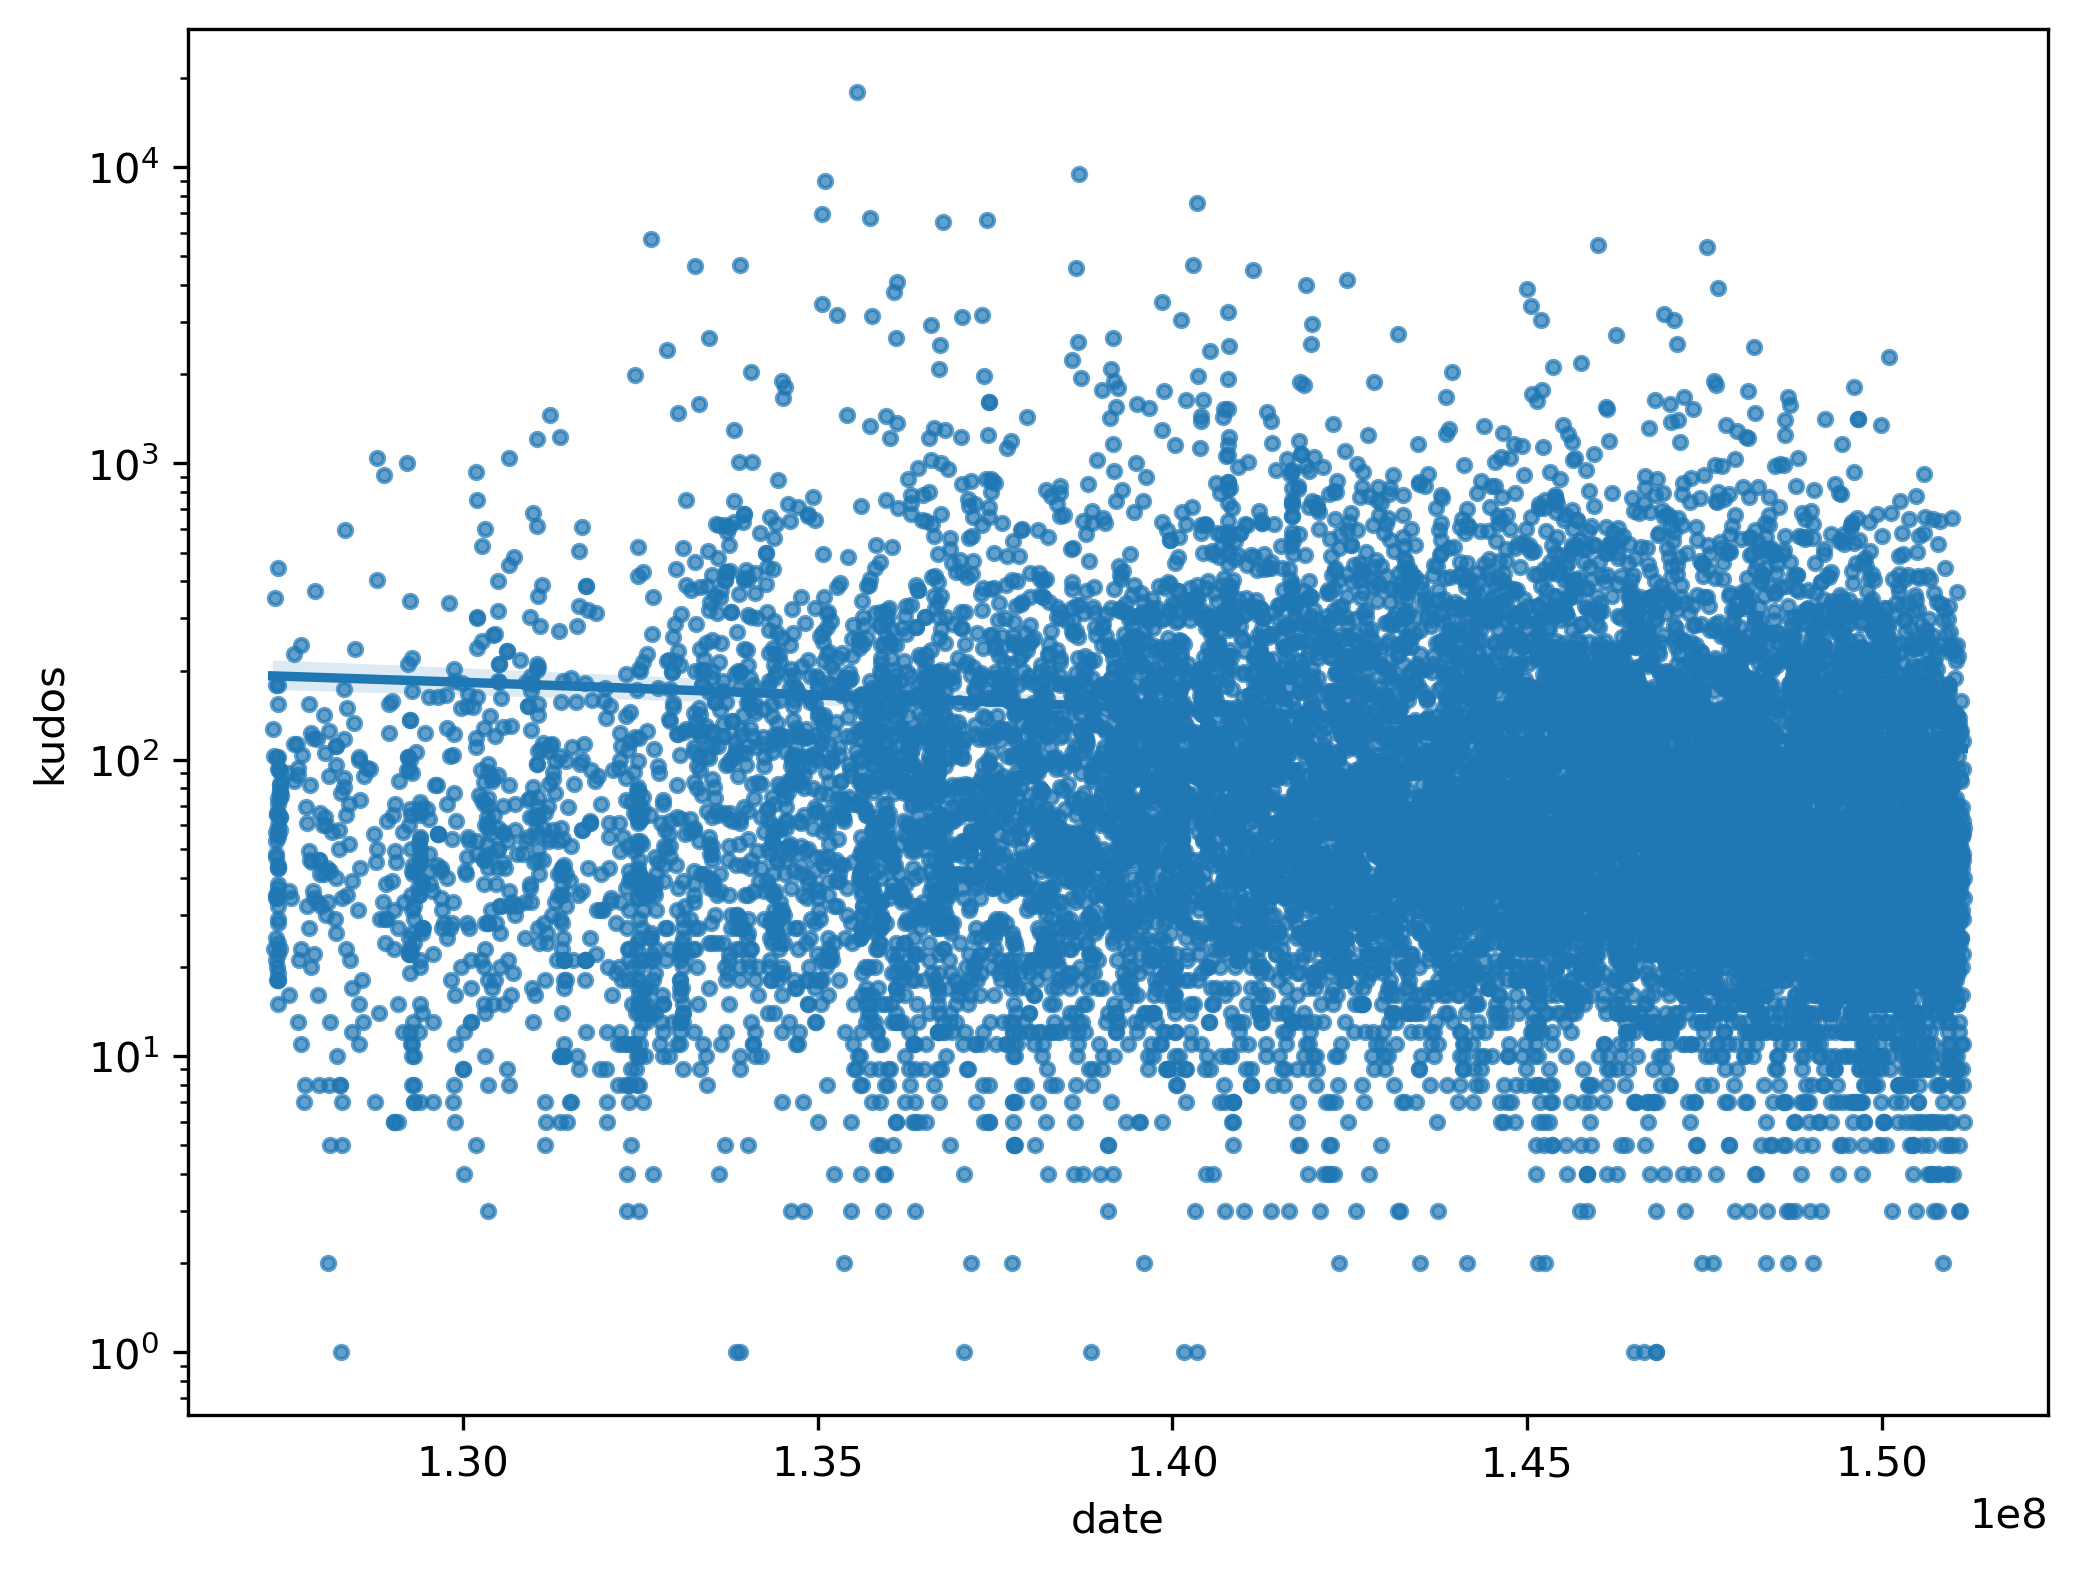

In [33]:
sns.regplot(data=df, x="date", y="kudos", scatter_kws={"s": 10, "alpha": 0.7})
plt.yscale("log")
plt.show()

> ANSWER
>
> It is almost impossible to see any effect from the scatterplot. On a regression plot we can see a very slightly negative regression line. Also notice that there is more data with higher `date` values (more recent work) which is a bias to keep in mind.

## Linear Regression

Using a "standard" linear regression with `statsmodels`, model `kudos` as the response variable with `date` as the predictor. What do you think? You should think about:
- how much variance is explained by `date`
- is the model 'confident' about its estimates?
- are the estimates "significant" (frequentist) or "credible" (Bayesian)?
- how about the *effect size*? Large? Small?

In [7]:
model = smf.ols("kudos ~ date", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  kudos   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     46.73
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           8.46e-12
Time:                        13:28:21   Log-Likelihood:            -1.0431e+05
No. Observations:               14371   AIC:                         2.086e+05
Df Residuals:                   14369   BIC:                         2.086e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    633.0836     72.772      8.699      0.0

> ANSWER
>
> The linear regression shows the same thing as the scatterplot. It can see only a very slight effect (a very tiny negative slope), and the $R^2$ is very low, suggesting that there are a lot of other factors that affect this kudos value (not unexpected). This also highlights another issue—you will see that the p-values are tiny, even though the effect size is negligible. This happens very often when there is a large amount of data, because bigger samples mean more confident estimates.
>
> TL;DR this is more or less a useless model.

## Bayesian Count Modelling

One of the reasons that the linear model was a problem is that "kudos" is really a count variable (it is always a non-negative integer). Since it accumulates over time, it is much more natural to model this with a more suitable distribution.

Using a Negative Binomial model, fit a Bayesian model with `bambi` that predicts `kudos` using `date`.

Because the date values a very large, the model will be *numerically unstable* and almost certainly fail without help. Here, the standard trick is to scale the data. The formula language has this built in. just write `scale(predictor)` instead of `predictor` in your formula.

Don't forget to use the magic incantation `idata_kwargs={"log_likelihood": True}` when fitting, so that we can do model comparisons later.

> NOTE
>
> Two things. First, some of these models will be slow - there is a *lot* of data. You can use `progressbar=True` in your call to `fit()`, or just wait it out. Second, it's possible that you might see some warning about either divergences or r-hat issues. For this exercise, just ignore them.

In [8]:
model = bmb.Model(
    "kudos ~ scale(date)",
    df,
    family="negativebinomial",
)
idata = model.fit(
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=True,
)
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, scale(date)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha        0.827  0.009   0.812    0.844        0.0      0.0    5608.0   
Intercept    4.901  0.009   4.883    4.918        0.0      0.0    5916.0   
scale(date) -0.167  0.010  -0.186   -0.148        0.0      0.0    6898.0   

             ess_tail  r_hat  
alpha          3119.0    1.0  
Intercept      2913.0    1.0  
scale(date)    2739.0    1.0

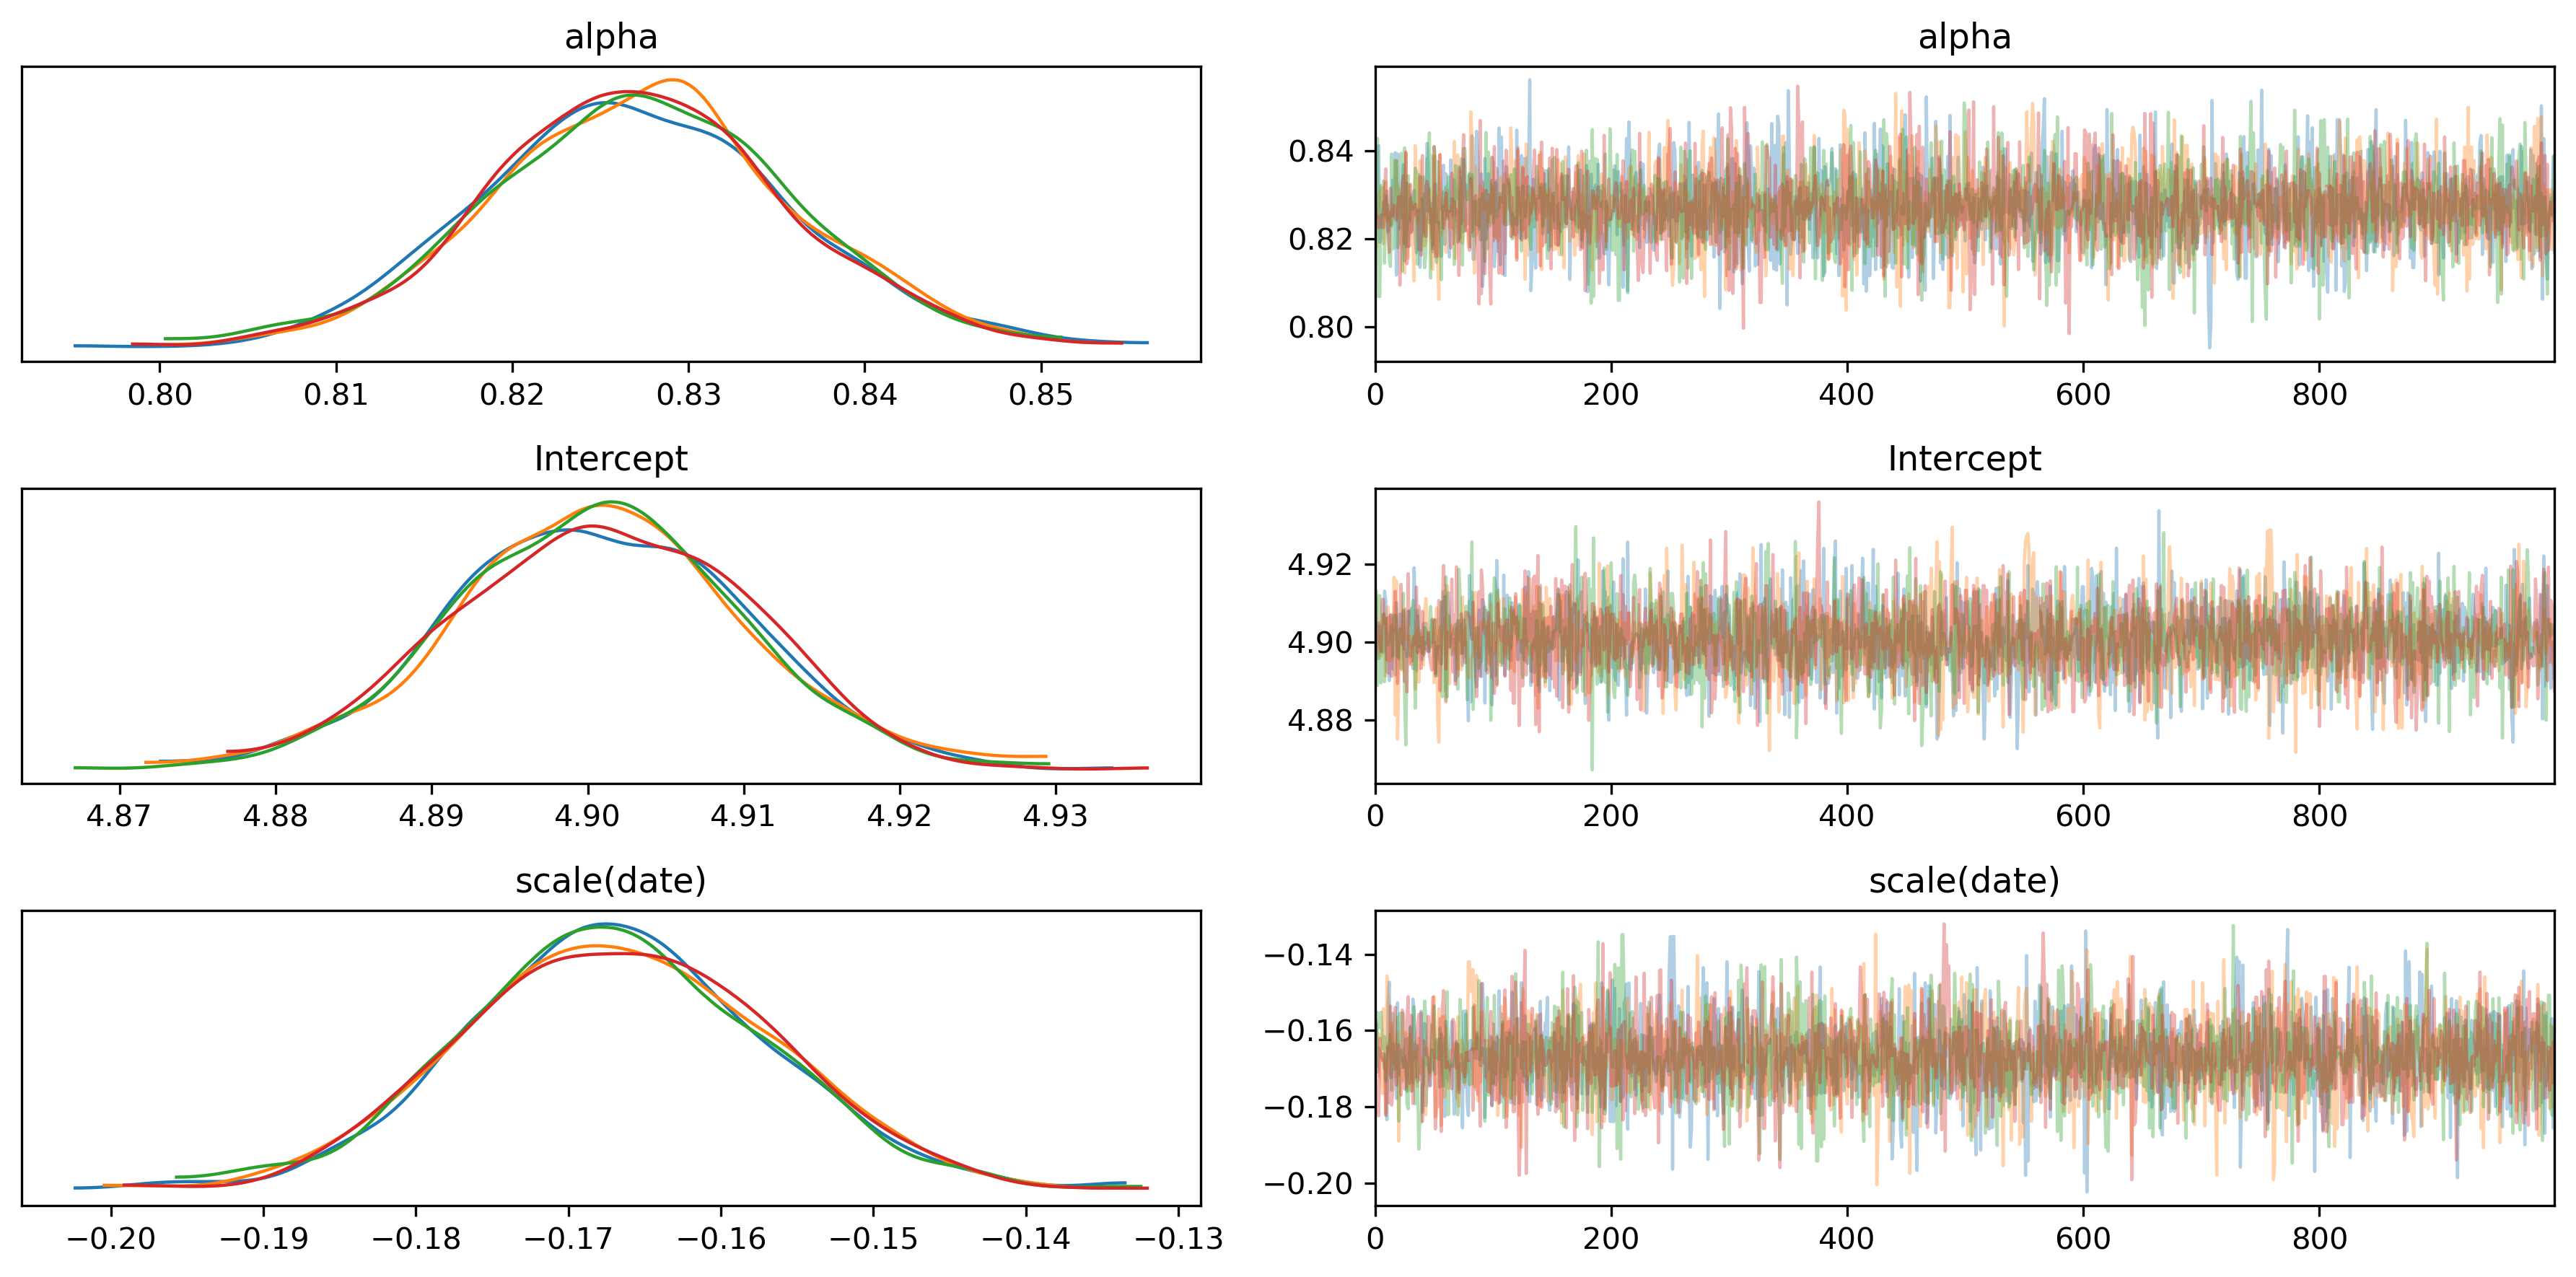

In [9]:
az.plot_trace(idata, compact=False)
plt.tight_layout()
plt.show()

## Interpret and view predictions

Based on the model output, what do you think about the effect of date? Is it real?

Next, plot the model prediction curve using `interpret.plot_predictions()`. Think about both the shape of the line and the confidence intervals.

Default computed for conditional variable: date


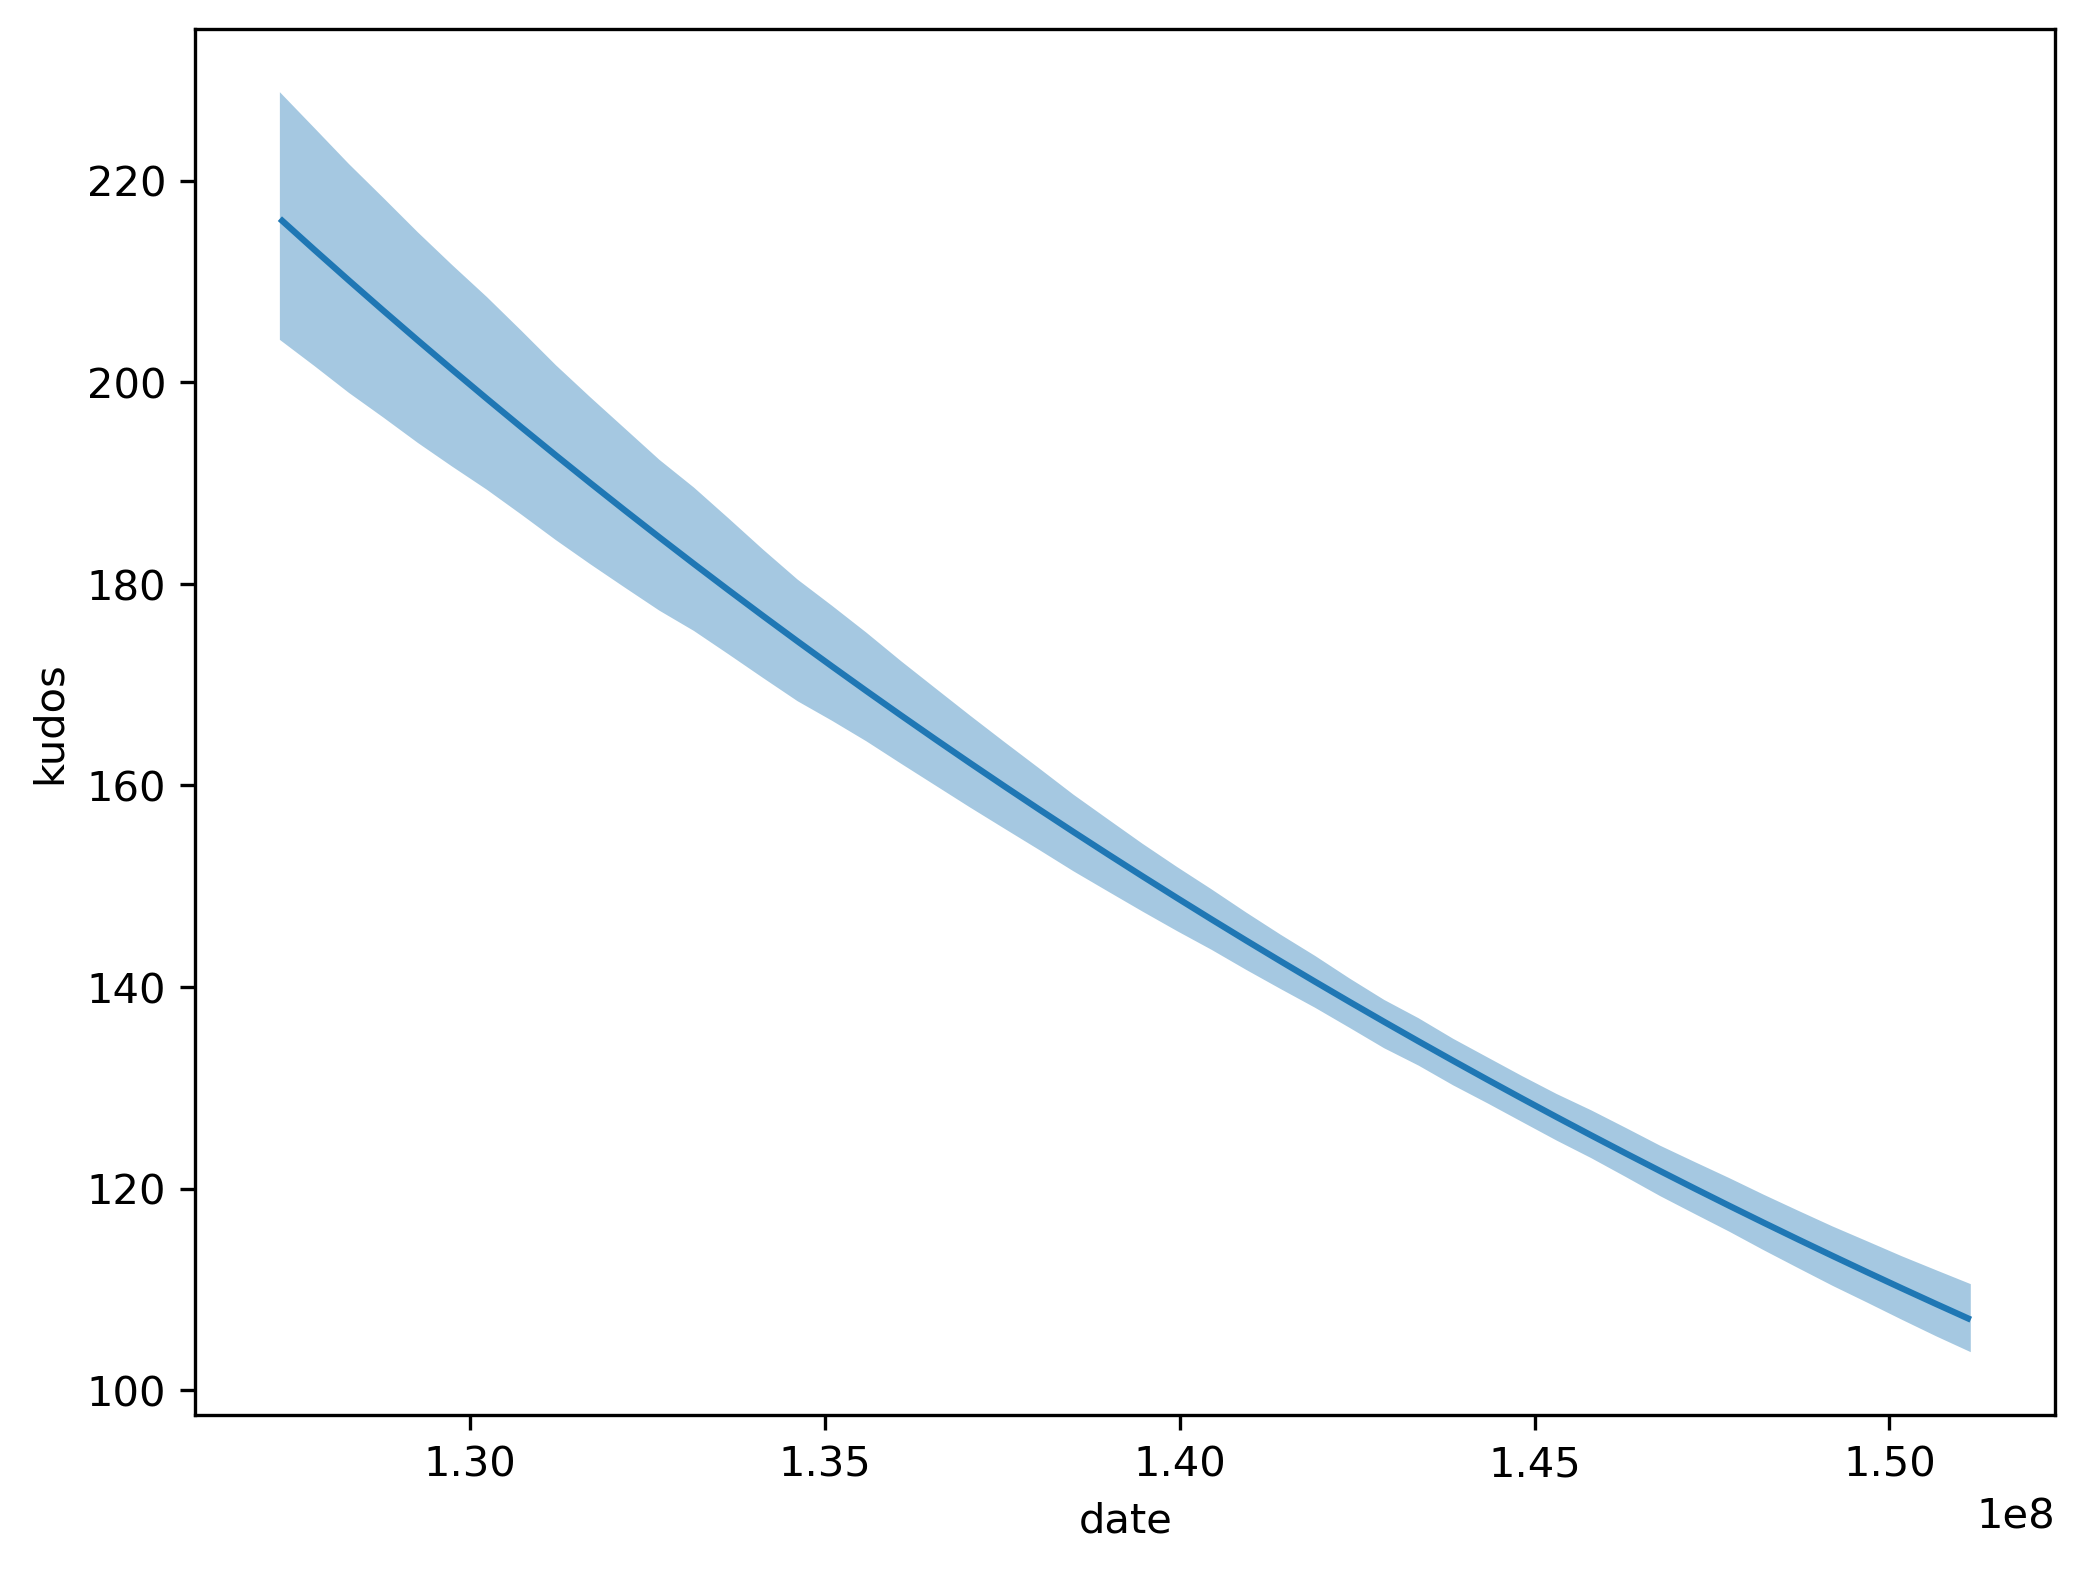

In [10]:
bmb.interpret.plot_predictions(
    model,
    idata,
    conditional=["date"],
)
plt.show()

> ANSWER
>
> The effect of date is definitely visible now! The High Density Interval shows that the model is less confident about estimates for older works. This is partially because the kudos numbers are bigger, but mostly because we have a recency bias in our observations (there are more newer works). This is not a problem, it is the model doing what it is supposed to do (making uncertainty visible)

## Sanity Check the PPC

As before, we will check the predictions from the posterior to see if they are "roughly" consistent with the real observations. Huge inconsistencies here usually mean that we are using the wrong model. Because of the variation in `kudos` we will use a log scale.

We give you the function to do this. Call it like `plot_ppc_log(model_variable, idata_variable, name_of_response_variable)`

You should see:
- The posterior *mean* (orange dashed)
- Many distributions from the posterior predictive (kudos values simulated by the model by exploring the predictor space)
- The empirical observed distribution (black line)

What is ideal is if the black line is entirely covered by the blue posterior distributions, which would mean that all the real outputs could be feasibly predicted by the model.

What do you think? Is our modelling approach "broadly" OK? Is the model over-predicting or under-predicting?

In [ ]:
def plot_ppc_log(model, idata, response: str, cut=False):
    # predict response variable (kudos) from many posterior distribution samples
    id = model.predict(idata, kind="response", inplace=False)
    # plot as log values to make easier to read
    ppd = np.log(id.posterior_predictive[response] + 1)
    obs = np.log(id.observed_data[response] + 1)
    var = f"log({response} + 1)"
    if cut:
        id.posterior_predictive[var] = ppd.where(ppd < cut, drop=True)
        id.observed_data[var] = obs.where(obs < cut)
    else:
        id.posterior_predictive[var] = ppd
        id.observed_data[var] = obs

    return az.plot_ppc(id, var_names=[var])

<Axes: xlabel='log(kudos + 1)'>

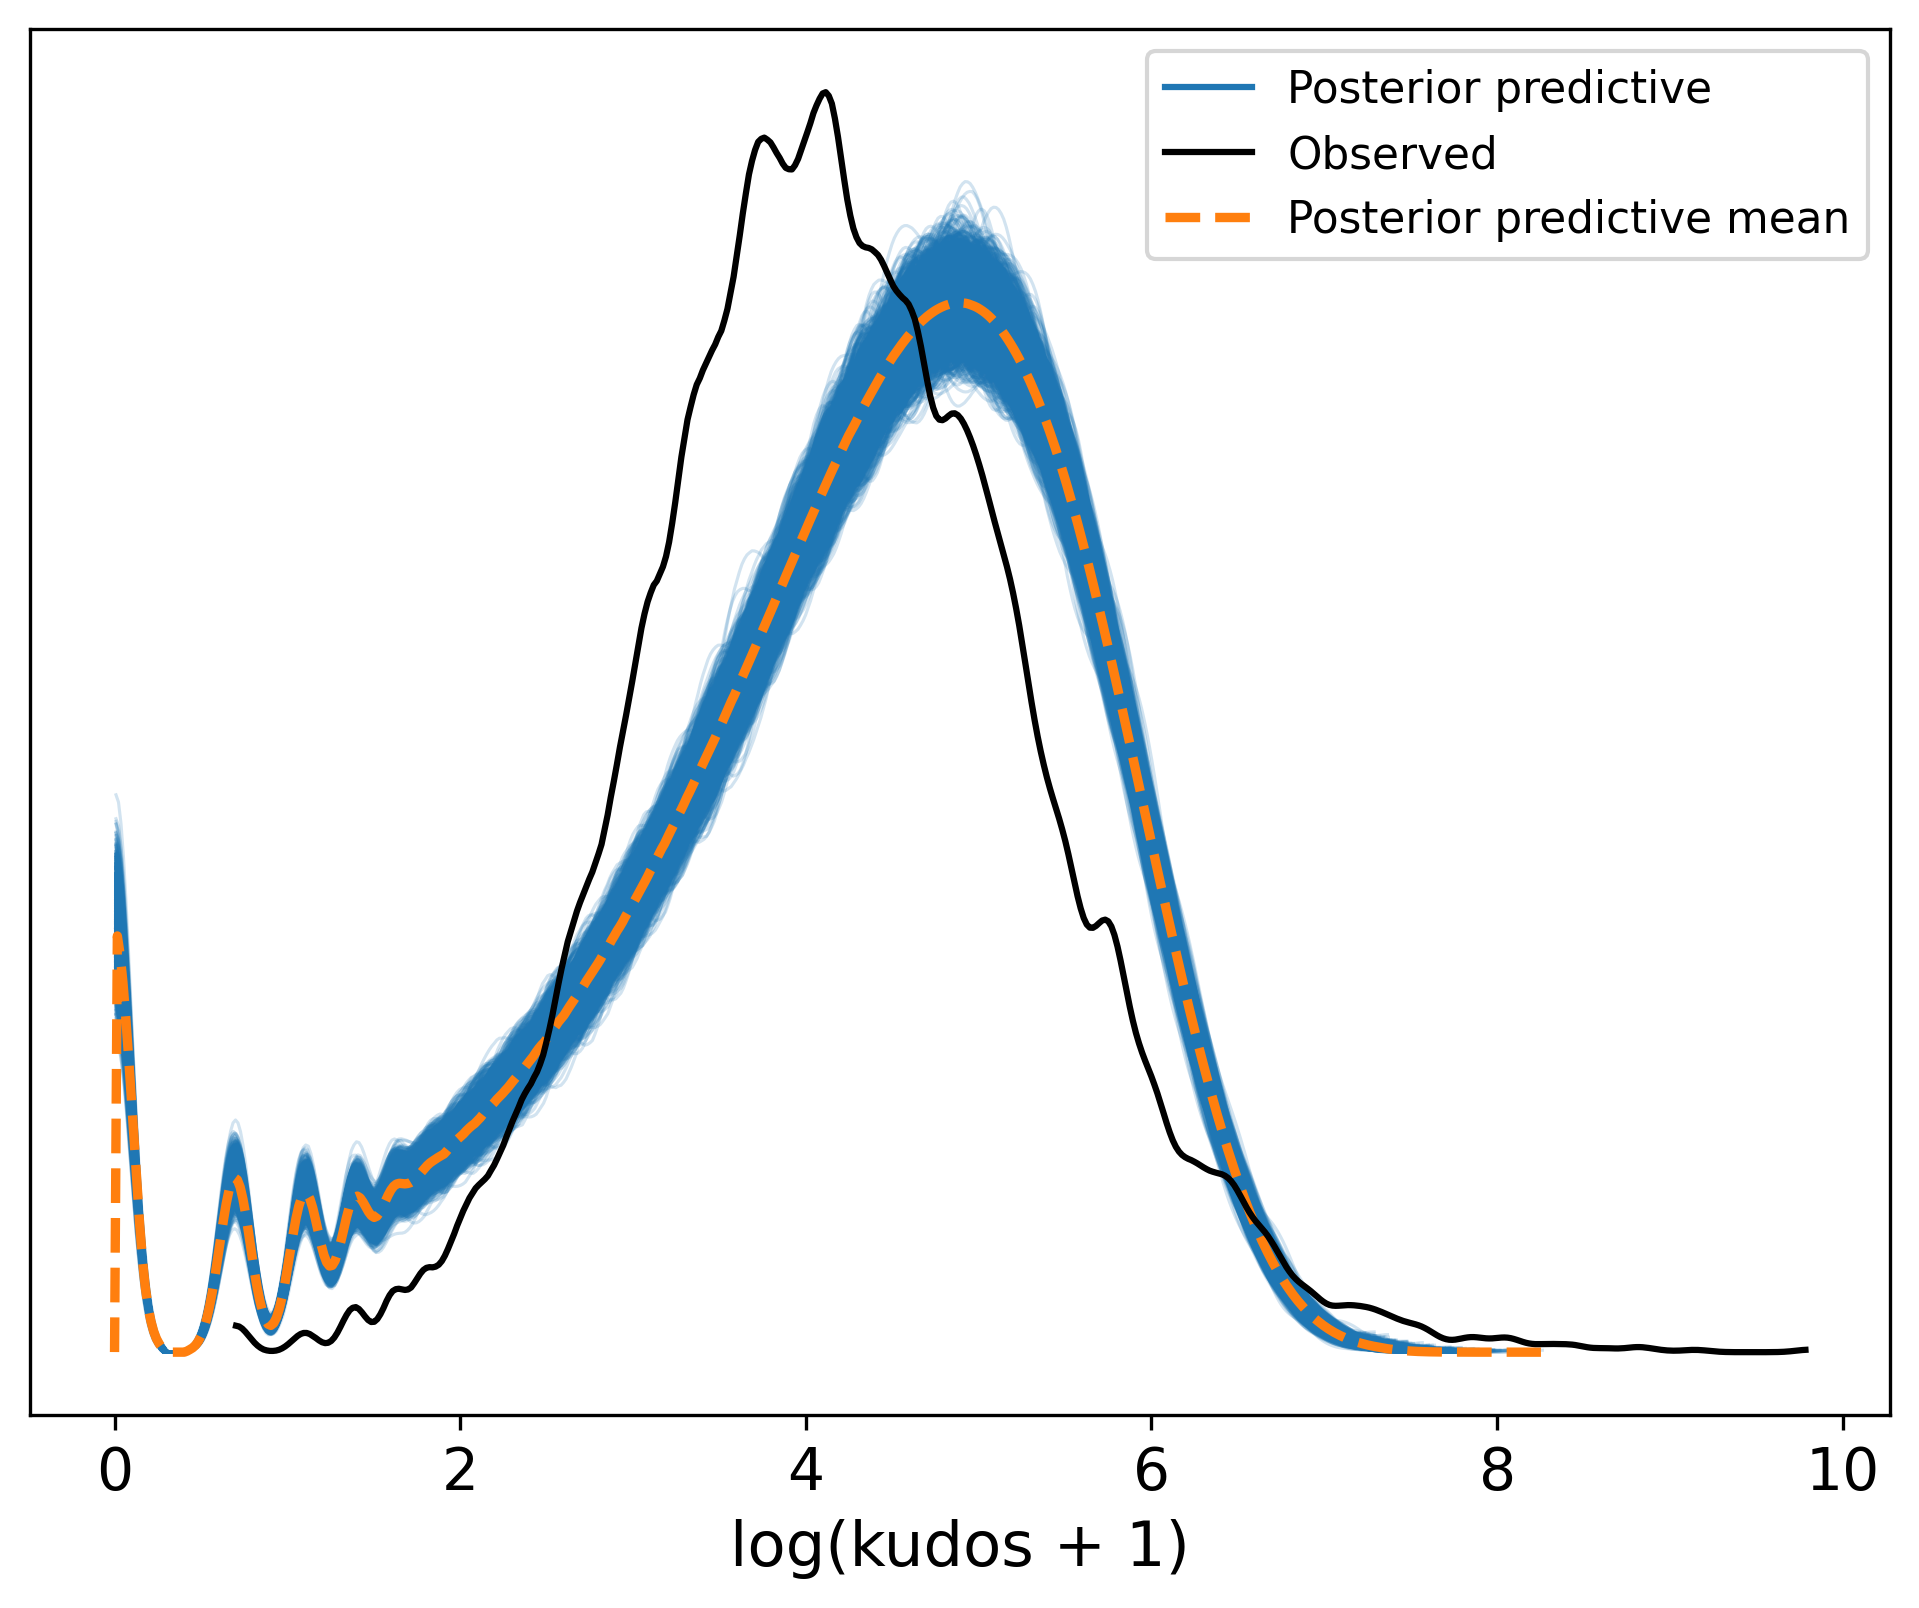

In [12]:
plot_ppc_log(
    model,
    idata,
    "kudos",
)

> ANSWER
> 
> We are on the right track, but there are still some problems. The general shape looks OK, but the model is predicting higher kudos, on average, than it should.

## Improve the model.

Now run three more models. Since there are many repeated measurements for author and fandom, it is natural to stratify by these variables by adding *mixed effects*. Recall that the purpose of a mixed effect is to allow each group of repeated observations to have its own slope. What we want to do is to allow to model to learn that some authors and fandoms are inherently more popular, and will naturally get more kudos (while still being affected by the kudos-over-time effect that we are modelling.)

Make one model with a random effect for `author`, one with `fandom` and one with both. Do not add any interaction terms. For each model, look at the PPC plot. This will take a while.

Out of author and fandom, which seems to help the model most?

Plot the predictions. What do you notice?

In [13]:
m2 = bmb.Model(
    "kudos ~ scale(date) + (1|author)",
    df,
    family="negativebinomial",
)
idata2 = m2.fit(
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=True,
)
az.summary(idata2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, scale(date), 1|author_sigma, 1|author_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 60 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha                     1.614  0.020   1.578    1.650      0.000    0.000   
Intercept                 4.355  0.019   4.317    4.391      0.001    0.001   
scale(date)              -0.117  0.012  -0.139   -0.095      0.000    0.000   
1|author_sigma            0.783  0.016   0.754    0.813      0.001    0.000   
1|author[0Zerotolerence]  0.390  0.442  -0.434    1.199      0.007    0.007   
...                         ...    ...     ...      ...        ...      ...   
1|author[zzzsleeptalker] -0.050  0.588  -1.108    1.071      0.010    0.011   
1|author[zzzubat]         0.993  0.380   0.295    1.704      0.006    0.005   
1|author[zzzz18]         -0.128  0.407  -0.875    0.637      0.006    0.007   
1|author[zzzzzz]         -0.432  0.497  -1.318    0.543      0.008    0.007   
1|author[zzzzzzzo]       -0.089  0.184  -0.406    0.272      0.003    0.003   

                          ess_bulk  ess_tail  r_hat  
alpha                       3314.0    2795.0   1.00  
Intercept                    452.0     900.0   1.01  
scale(date)                 1305.0    1924.0   1.00  
1|author_sigma               579.0    1004.0   1.00  
1|author[0Zerotolerence]    4485.0    2378.0   1.00  
...                            ...       ...    ...  
1|author[zzzsleeptalker]    3834.0    2588.0   1.00  
1|author[zzzubat]           4208.0    2414.0   1.00  
1|author[zzzz18]            4234.0    2152.0   1.00  
1|author[zzzzzz]            3916.0    2552.0   1.00  
1|author[zzzzzzzo]          4649.0    2510.0   1.00  

[2742 rows x 9 columns]

Default computed for conditional variable: date
Default computed for unspecified variable: author


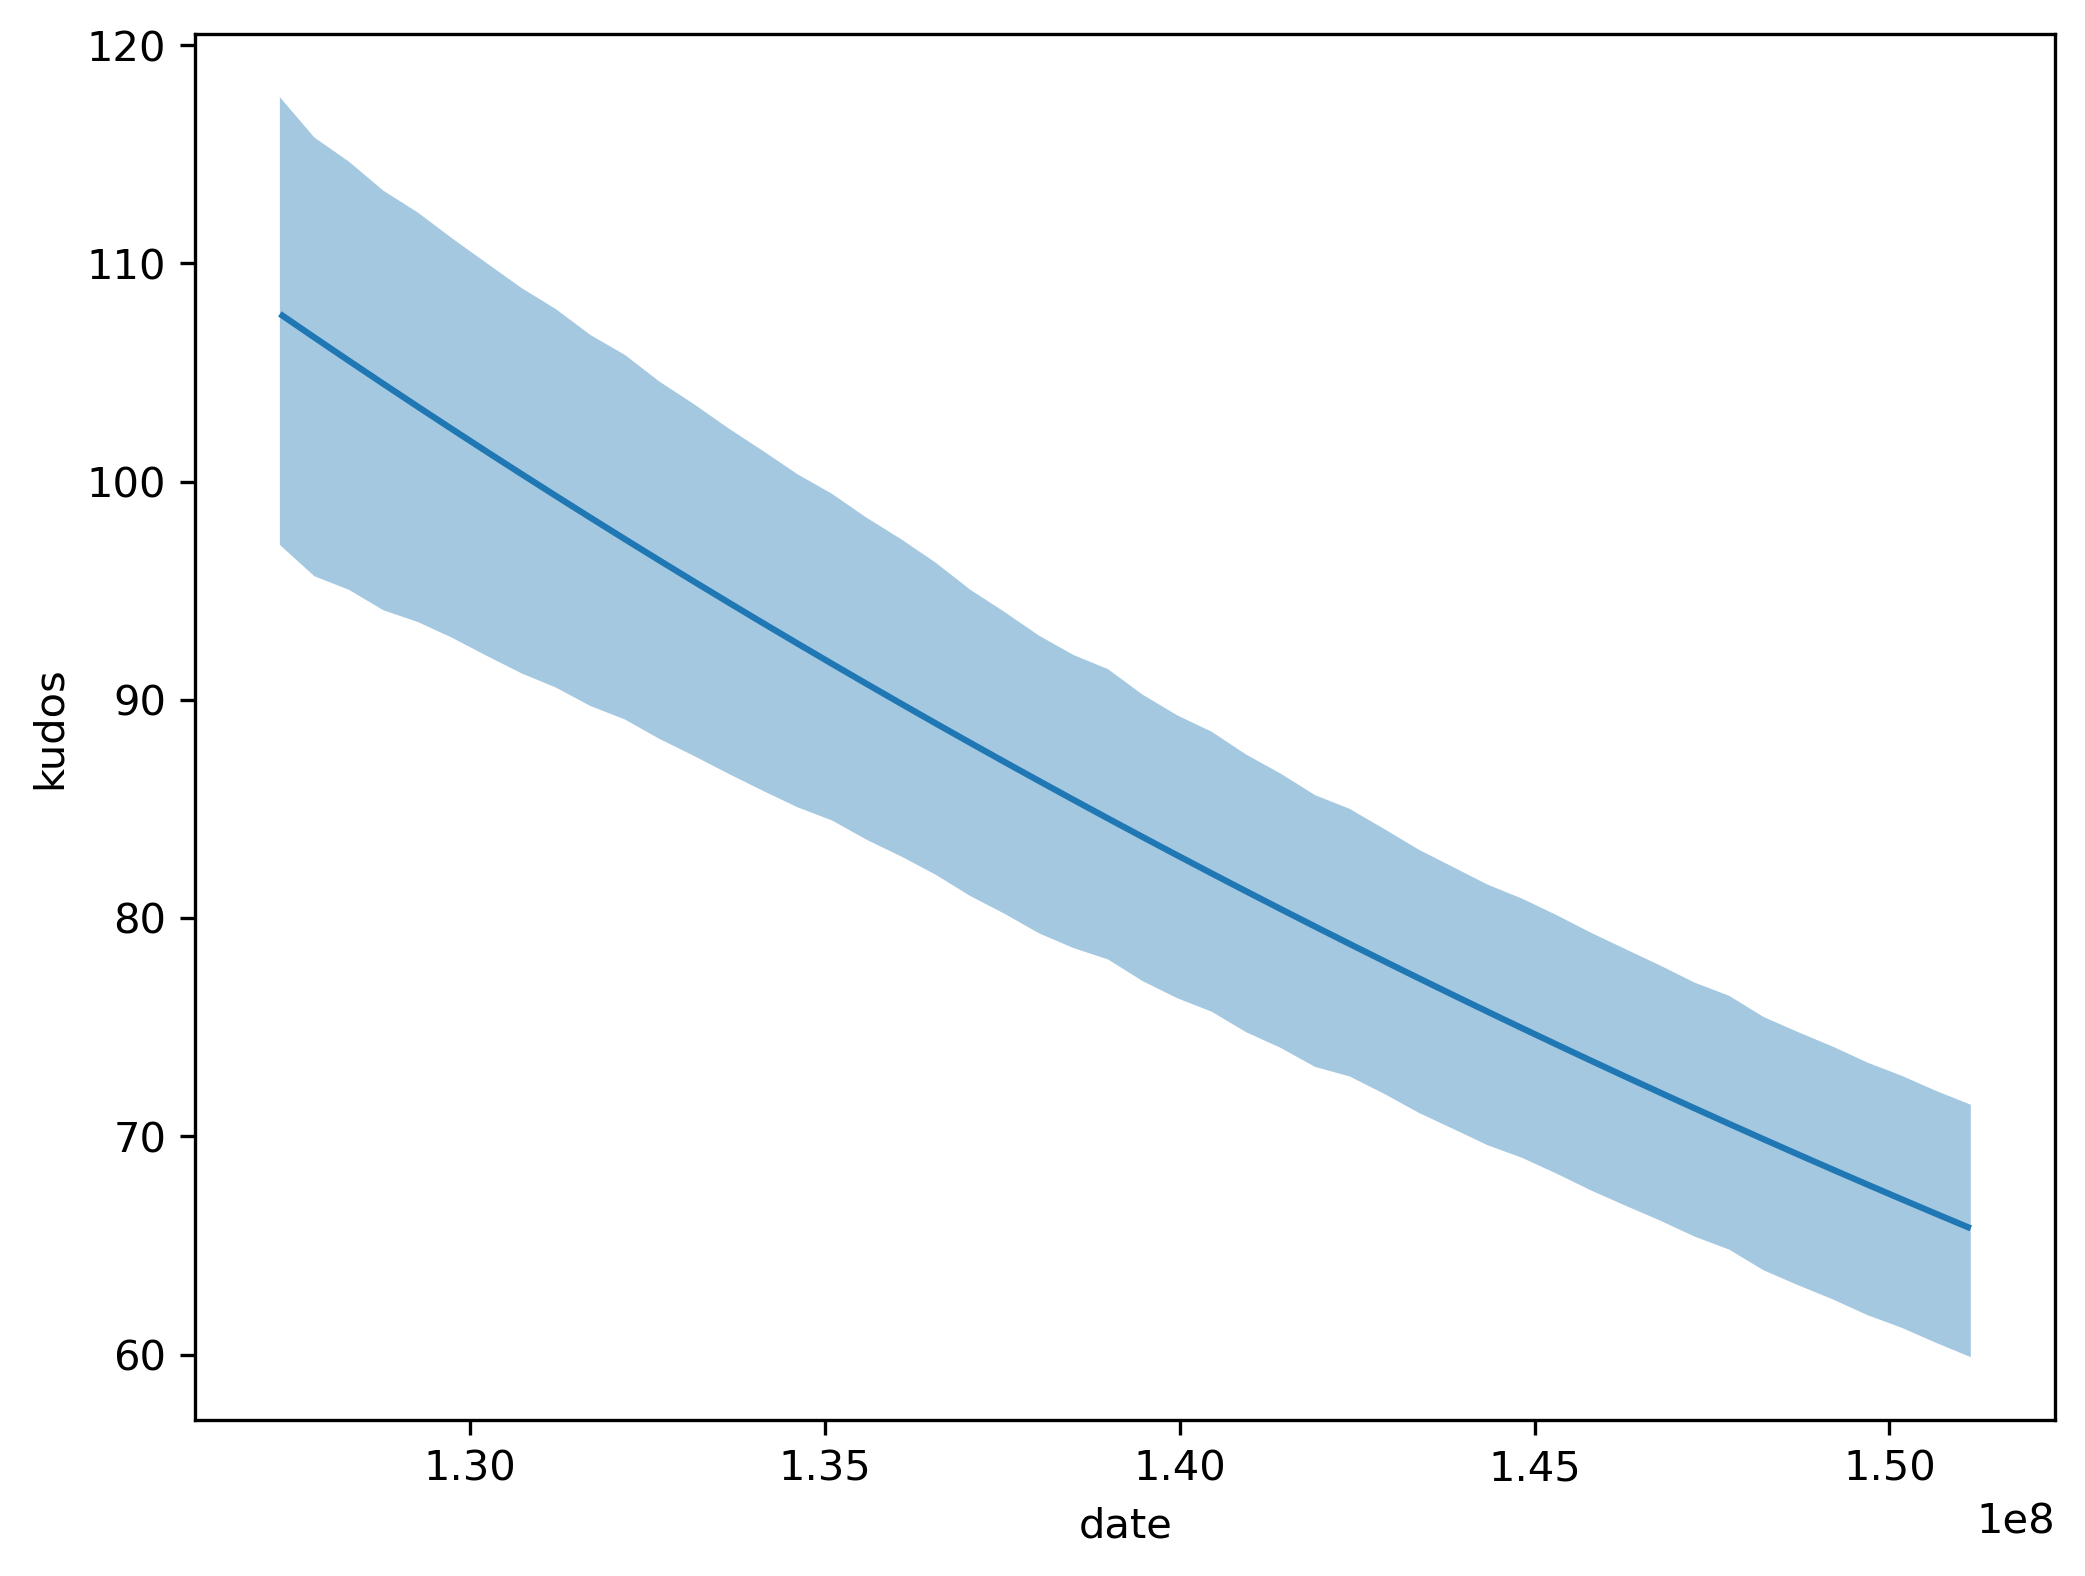

In [14]:
bmb.interpret.plot_predictions(
    m2,
    idata2,
    conditional=["date"],
)
plt.show()

<Axes: xlabel='log(kudos + 1)'>

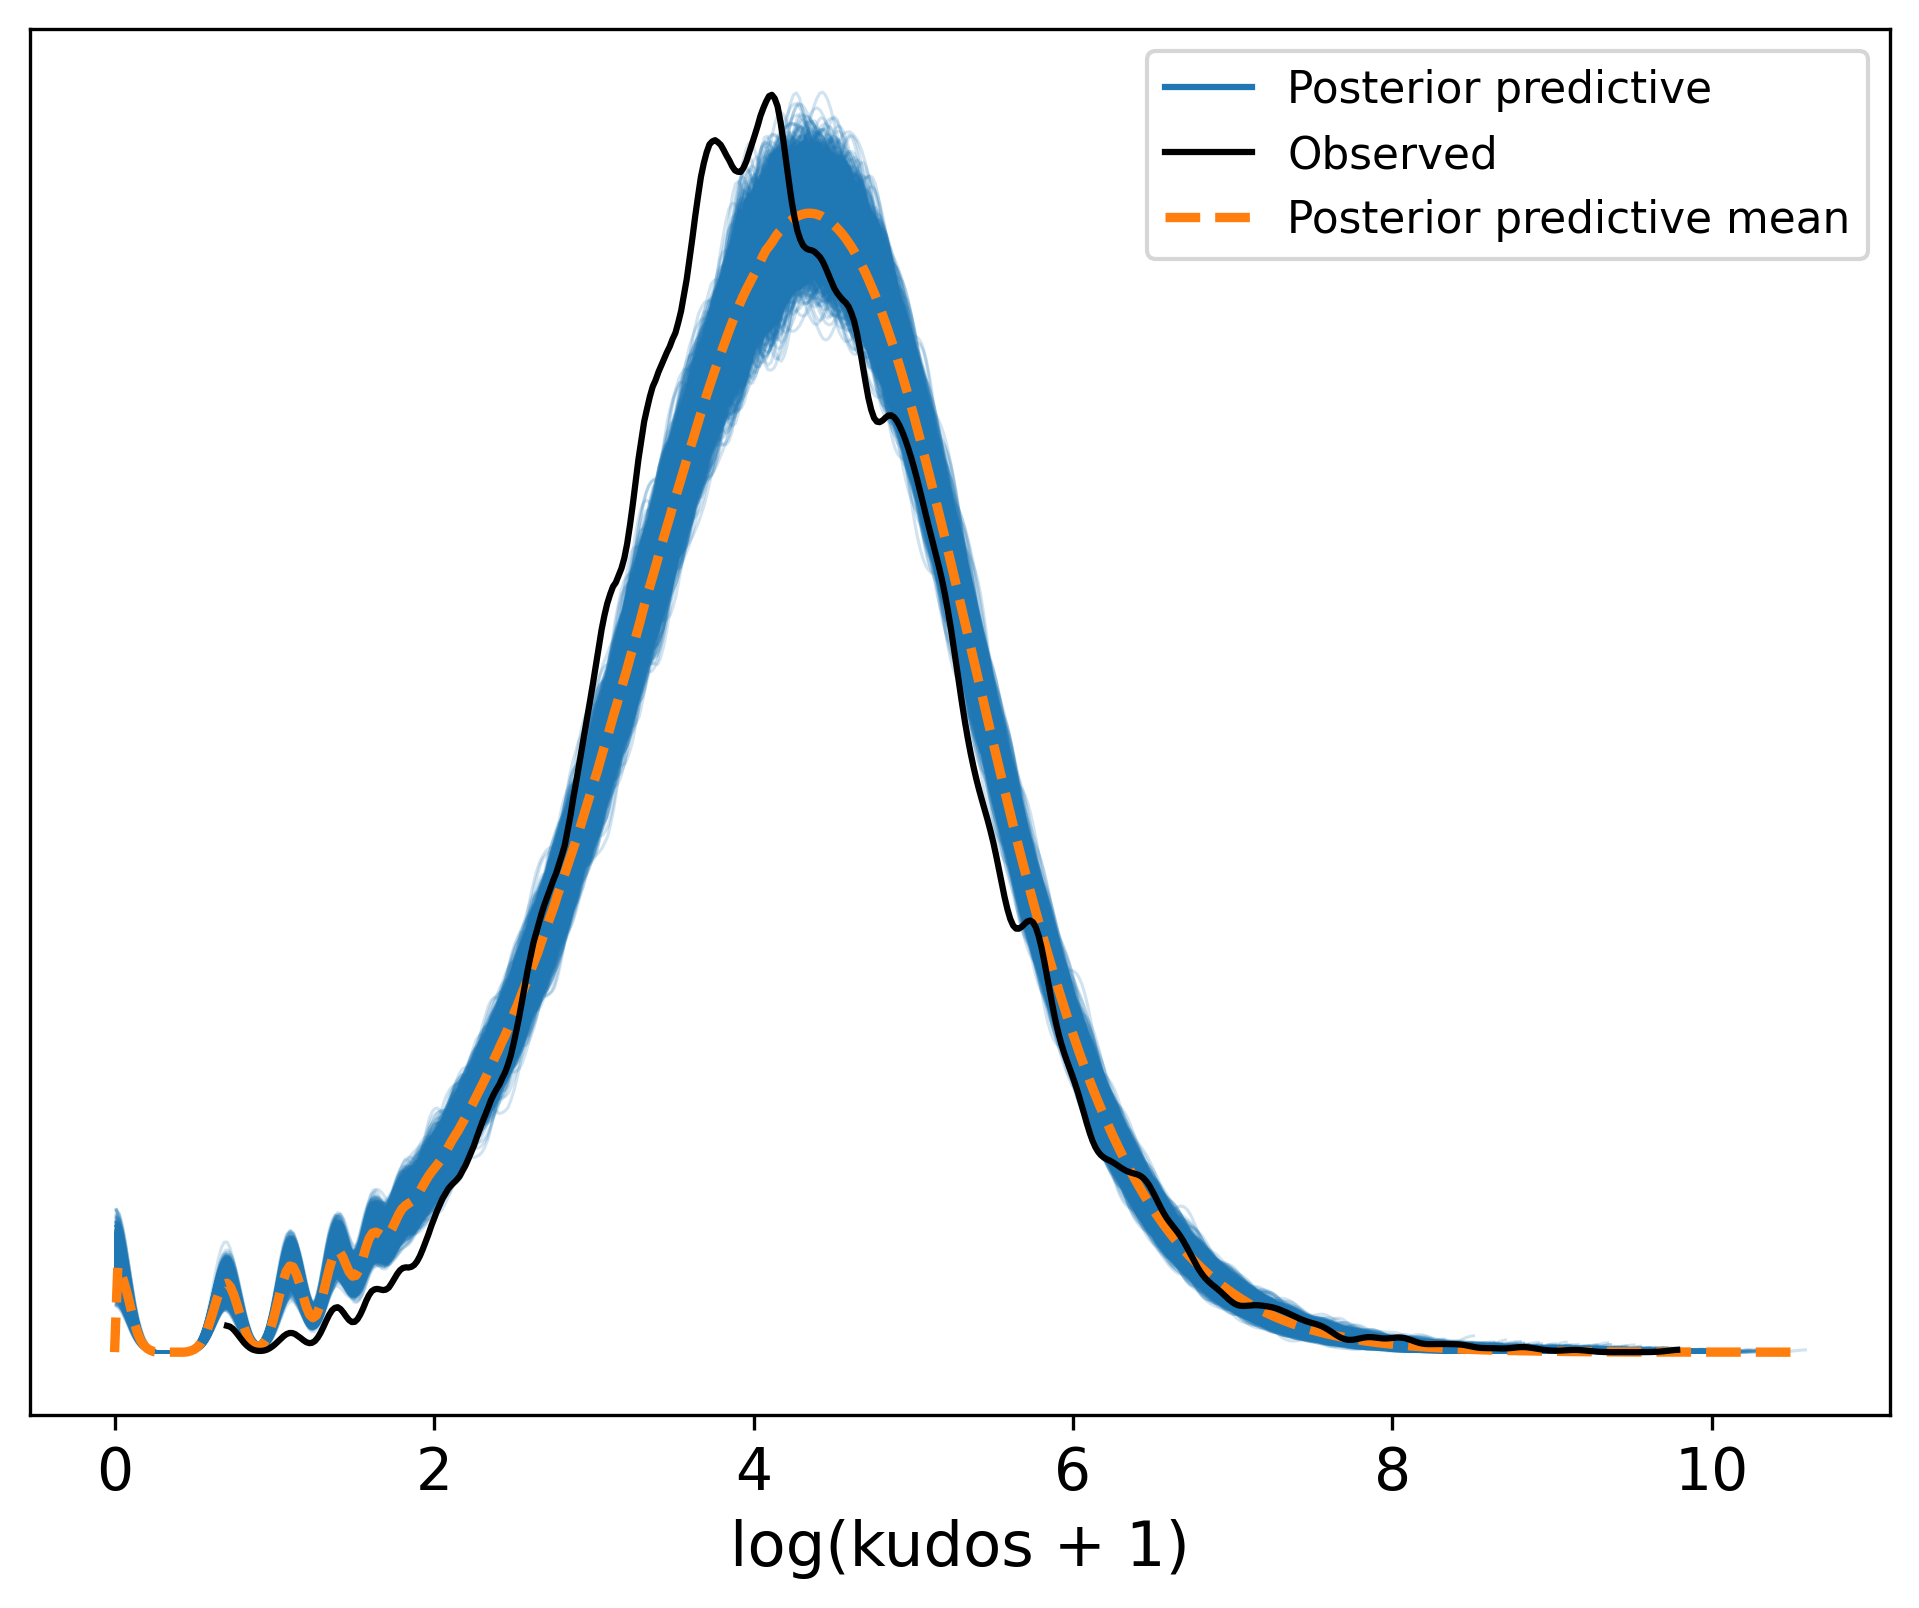

In [15]:
plot_ppc_log(
    m2,
    idata2,
    "kudos",
)

In [16]:
m3 = bmb.Model(
    "kudos ~ scale(date) + (1|fandom)",
    df,
    family="negativebinomial",
)
idata3 = m3.fit(
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=True,
)
az.summary(idata3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, scale(date), 1|fandom_sigma, 1|fandom_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


mean     sd  hdi_3%  \
alpha                                               1.227  0.014   1.201   
Intercept                                           4.306  0.021   4.267   
scale(date)                                        -0.248  0.012  -0.270   
1|fandom_sigma                                      0.789  0.019   0.753   
1|fandom[#FindTheGirlsOnTheNegatives]               0.012  0.600  -1.049   
...                                                   ...    ...     ...   
1|fandom[yuri on ice]                               0.164  0.409  -0.587   
1|fandom[yuri on ice, Yuri!!! on ICE]               0.525  0.541  -0.457   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...  0.314  0.158   0.010   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n... -0.286  0.674  -1.613   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n... -0.204  0.639  -1.378   

                                                    hdi_97%  mcse_mean  \
alpha                                                 1.253      0.000   
Intercept                                             4.346      0.001   
scale(date)                                          -0.225      0.000   
1|fandom_sigma                                        0.825      0.001   
1|fandom[#FindTheGirlsOnTheNegatives]                 1.171      0.009   
...                                                     ...        ...   
1|fandom[yuri on ice]                                 0.946      0.007   
1|fandom[yuri on ice, Yuri!!! on ICE]                 1.576      0.008   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    0.599      0.003   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    0.926      0.010   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    0.988      0.010   

                                                    mcse_sd  ess_bulk  \
alpha                                                 0.000    2868.0   
Intercept                                             0.001     660.0   
scale(date)                                           0.000    1815.0   
1|fandom_sigma                                        0.001     648.0   
1|fandom[#FindTheGirlsOnTheNegatives]                 0.011    4424.0   
...                                                     ...       ...   
1|fandom[yuri on ice]                                 0.007    3909.0   
1|fandom[yuri on ice, Yuri!!! on ICE]                 0.008    4312.0   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    0.002    3554.0   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    0.011    4527.0   
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    0.011    4079.0   

                                                    ess_tail  r_hat  
alpha                                                 2365.0   1.00  
Intercept                                             1243.0   1.00  
scale(date)                                           2323.0   1.00  
1|fandom_sigma                                        1116.0   1.01  
1|fandom[#FindTheGirlsOnTheNegatives]                 2488.0   1.00  
...                                                      ...    ...  
1|fandom[yuri on ice]                                 2185.0   1.00  
1|fandom[yuri on ice, Yuri!!! on ICE]                 2297.0   1.00  
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    2443.0   1.00  
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    2767.0   1.00  
1|fandom[ziyoziyonoQi Miao naMou Xian  | JoJo n...    2619.0   1.00  

[2752 rows x 9 columns]

<Axes: xlabel='log(kudos + 1)'>

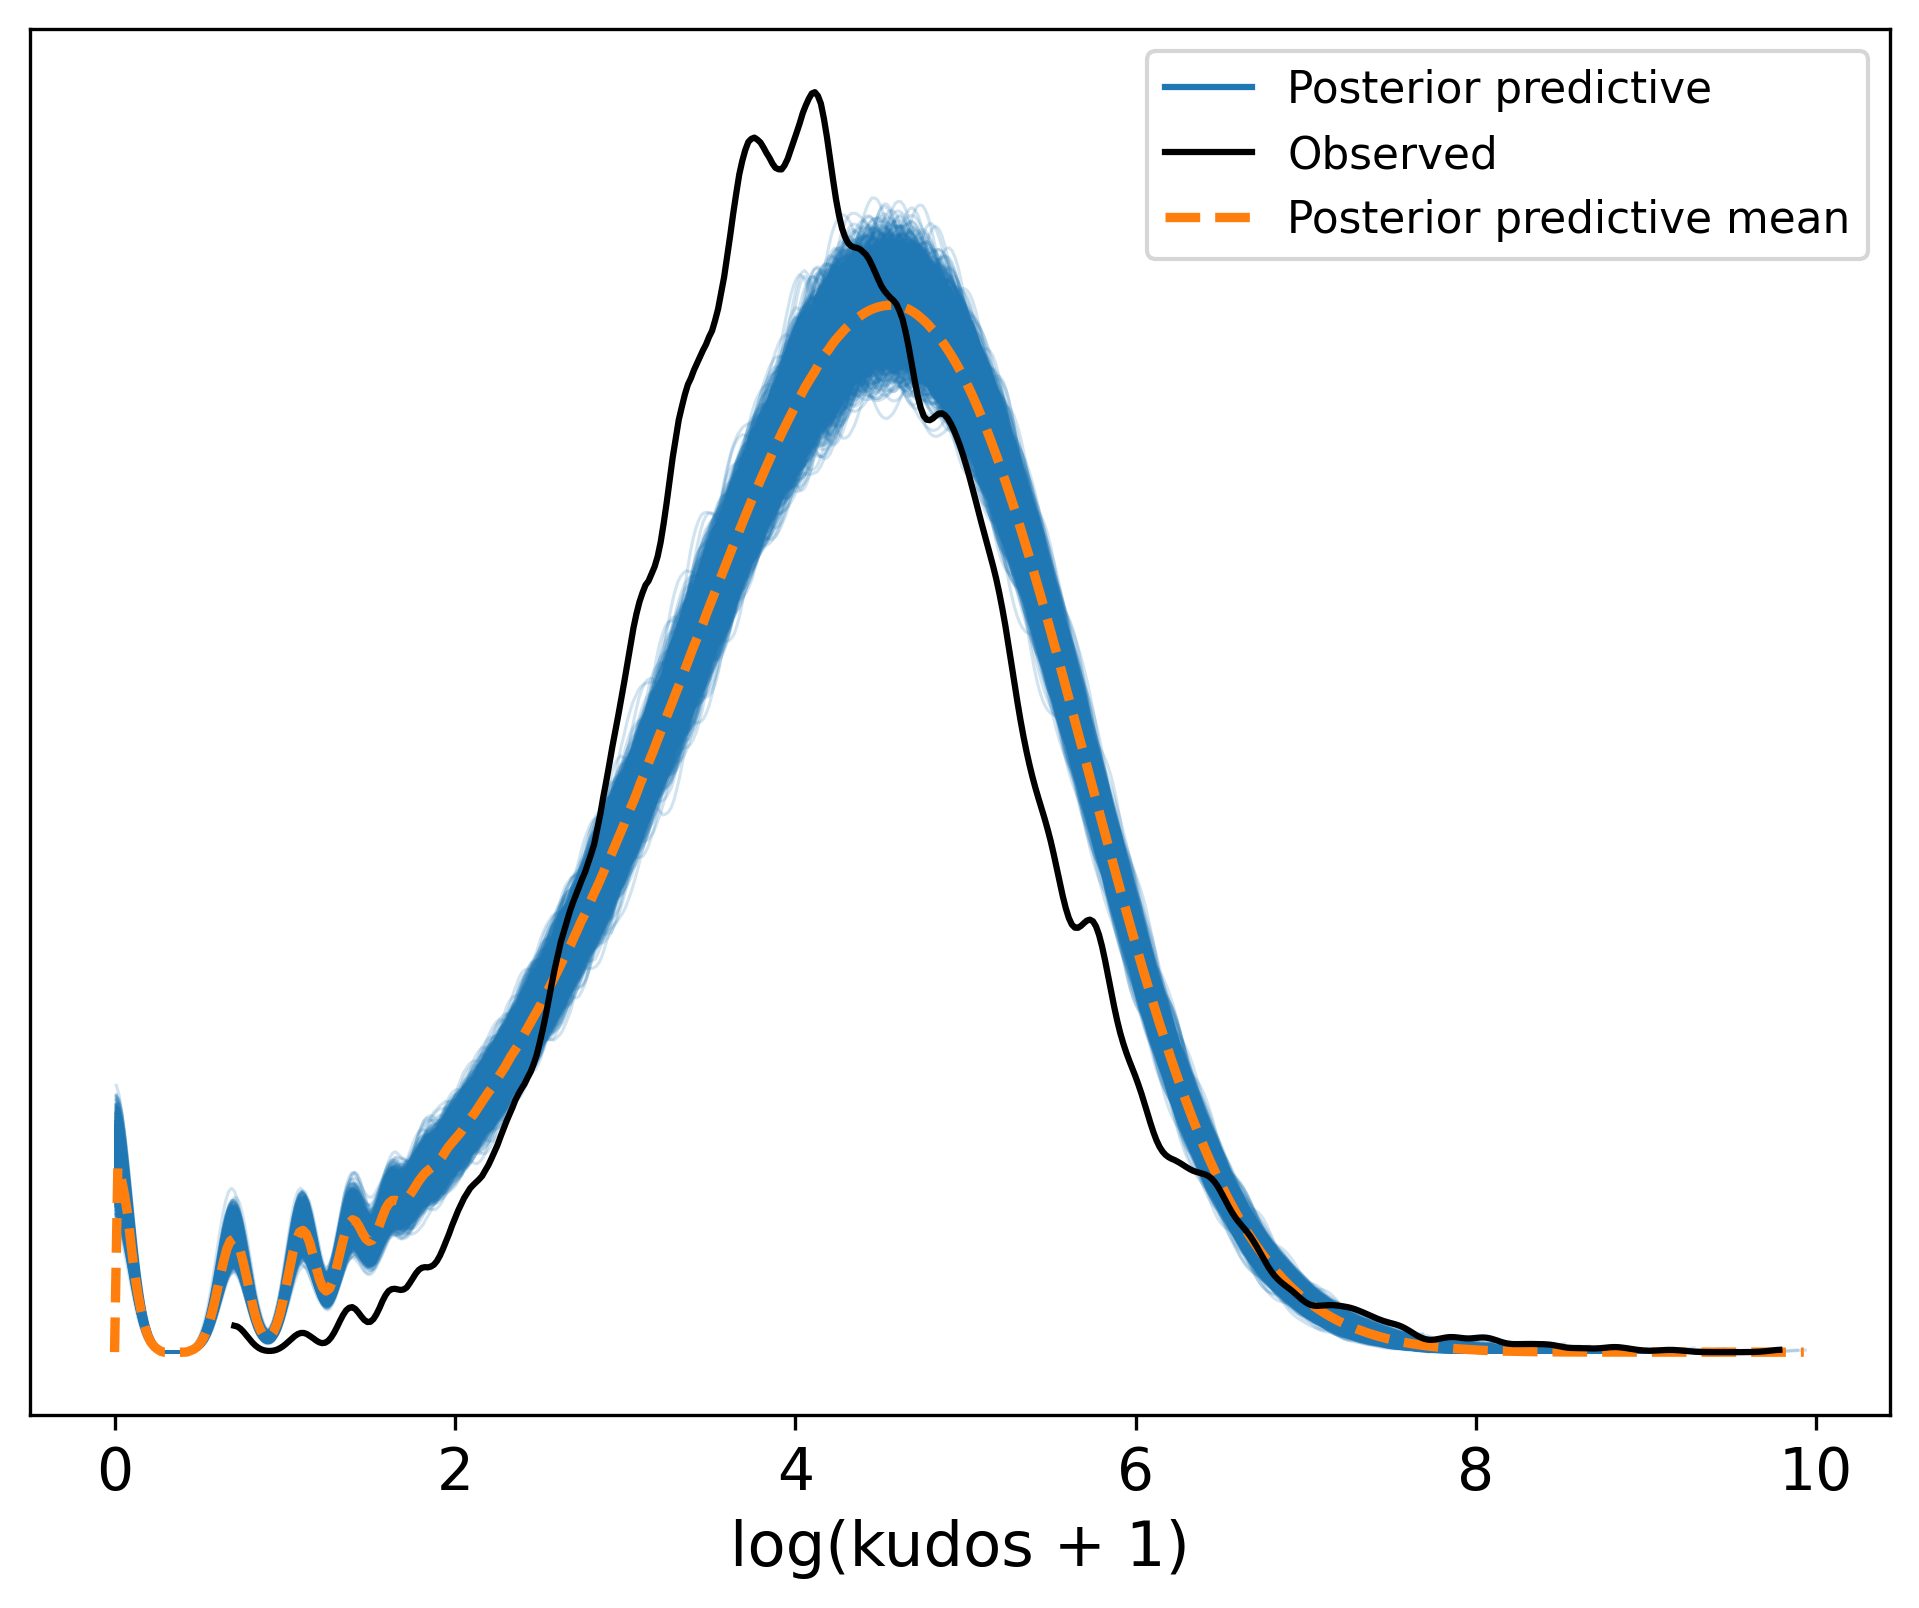

In [17]:
plot_ppc_log(
    m3,
    idata3,
    "kudos",
)

In [18]:
m4 = bmb.Model(
    "kudos ~ scale(date) + (1|fandom) + (1|author)",
    df,
    family="negativebinomial",
)
idata4 = m4.fit(
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=True,
)
summary4 = az.summary(idata4)
summary4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, scale(date), 1|fandom_sigma, 1|fandom_offset, 1|author_sigma, 1|author_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha                     2.033  0.028   1.980    2.083      0.001    0.000   
Intercept                 4.122  0.025   4.079    4.173      0.001    0.000   
scale(date)              -0.208  0.013  -0.233   -0.183      0.000    0.000   
1|fandom_sigma            0.628  0.018   0.595    0.662      0.001    0.000   
1|author_sigma            0.717  0.016   0.688    0.745      0.000    0.000   
...                         ...    ...     ...      ...        ...      ...   
1|author[zzzsleeptalker] -0.027  0.528  -1.010    0.958      0.007    0.010   
1|author[zzzubat]         0.597  0.440  -0.213    1.442      0.007    0.006   
1|author[zzzz18]         -0.278  0.405  -1.052    0.441      0.005    0.005   
1|author[zzzzzz]         -0.178  0.505  -1.123    0.746      0.007    0.008   
1|author[zzzzzzzo]        0.076  0.213  -0.326    0.467      0.003    0.003   

                          ess_bulk  ess_tail  r_hat  
alpha                       2395.0    2384.0    1.0  
Intercept                   1419.0    1948.0    1.0  
scale(date)                 2765.0    2658.0    1.0  
1|fandom_sigma              1128.0    2072.0    1.0  
1|author_sigma              1214.0    1981.0    1.0  
...                            ...       ...    ...  
1|author[zzzsleeptalker]    6508.0    2354.0    1.0  
1|author[zzzubat]           4497.0    2880.0    1.0  
1|author[zzzz18]            6017.0    3075.0    1.0  
1|author[zzzzzz]            5160.0    3073.0    1.0  
1|author[zzzzzzzo]          4528.0    3390.0    1.0  

[5491 rows x 9 columns]

Default computed for conditional variable: date
Default computed for unspecified variable: author, fandom


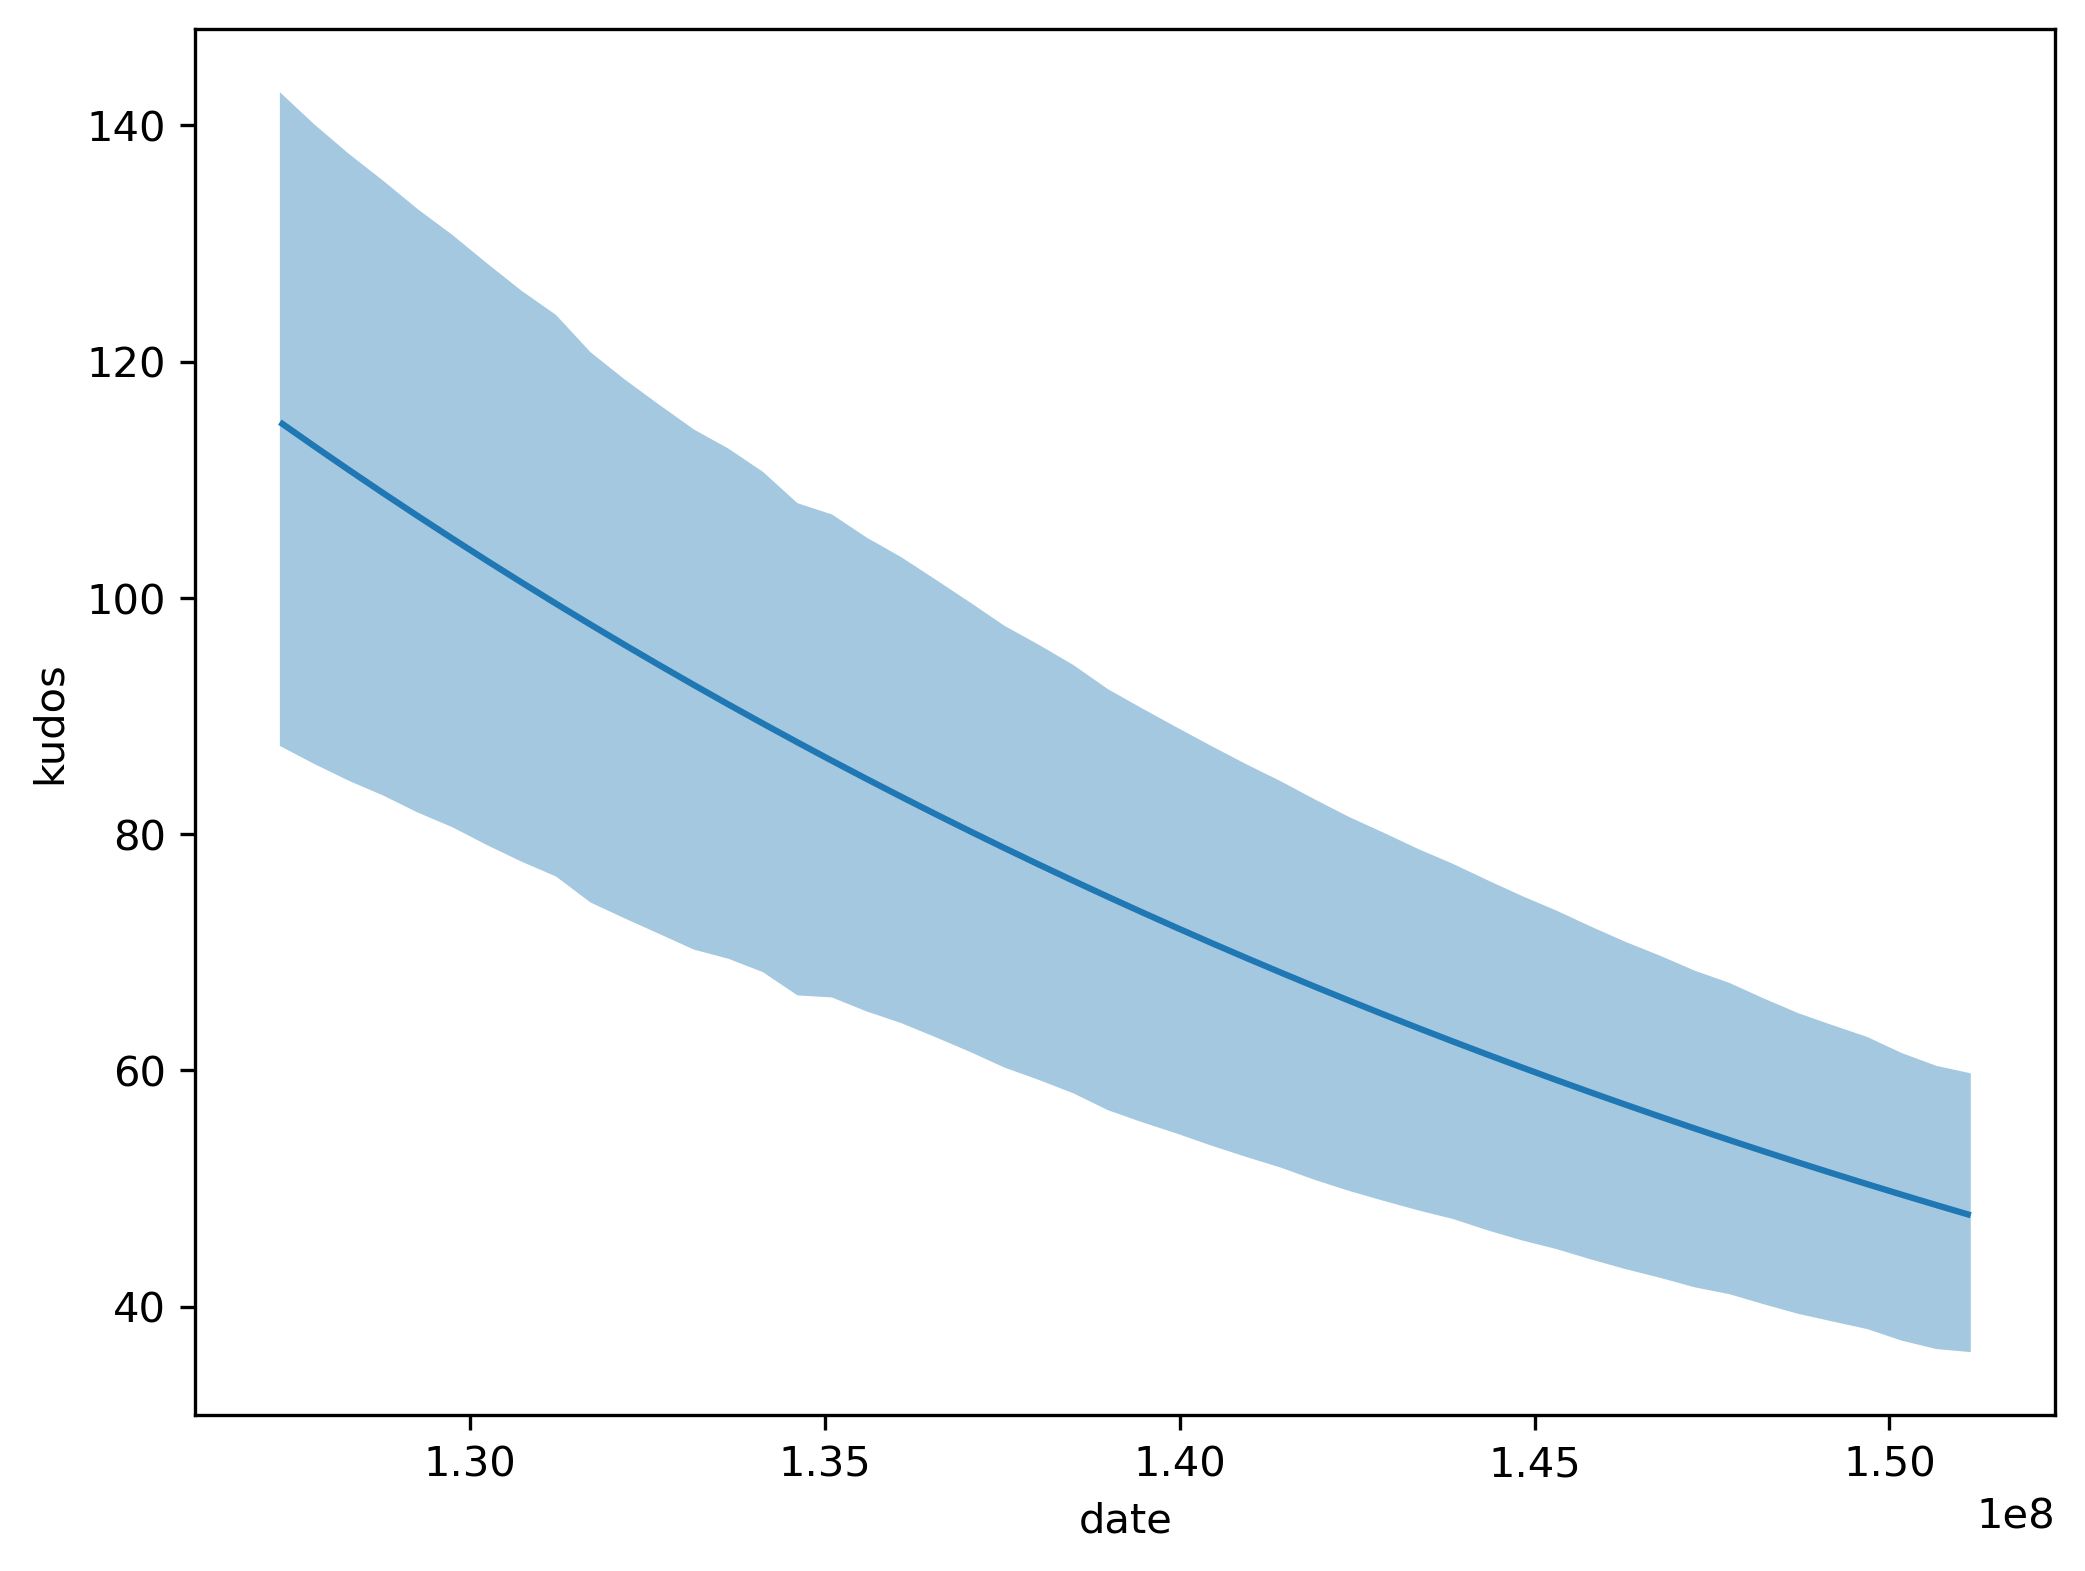

In [19]:
bmb.interpret.plot_predictions(
    m4,
    idata4,
    conditional=["date"],
)
plt.show()

<Axes: xlabel='log(kudos + 1)'>

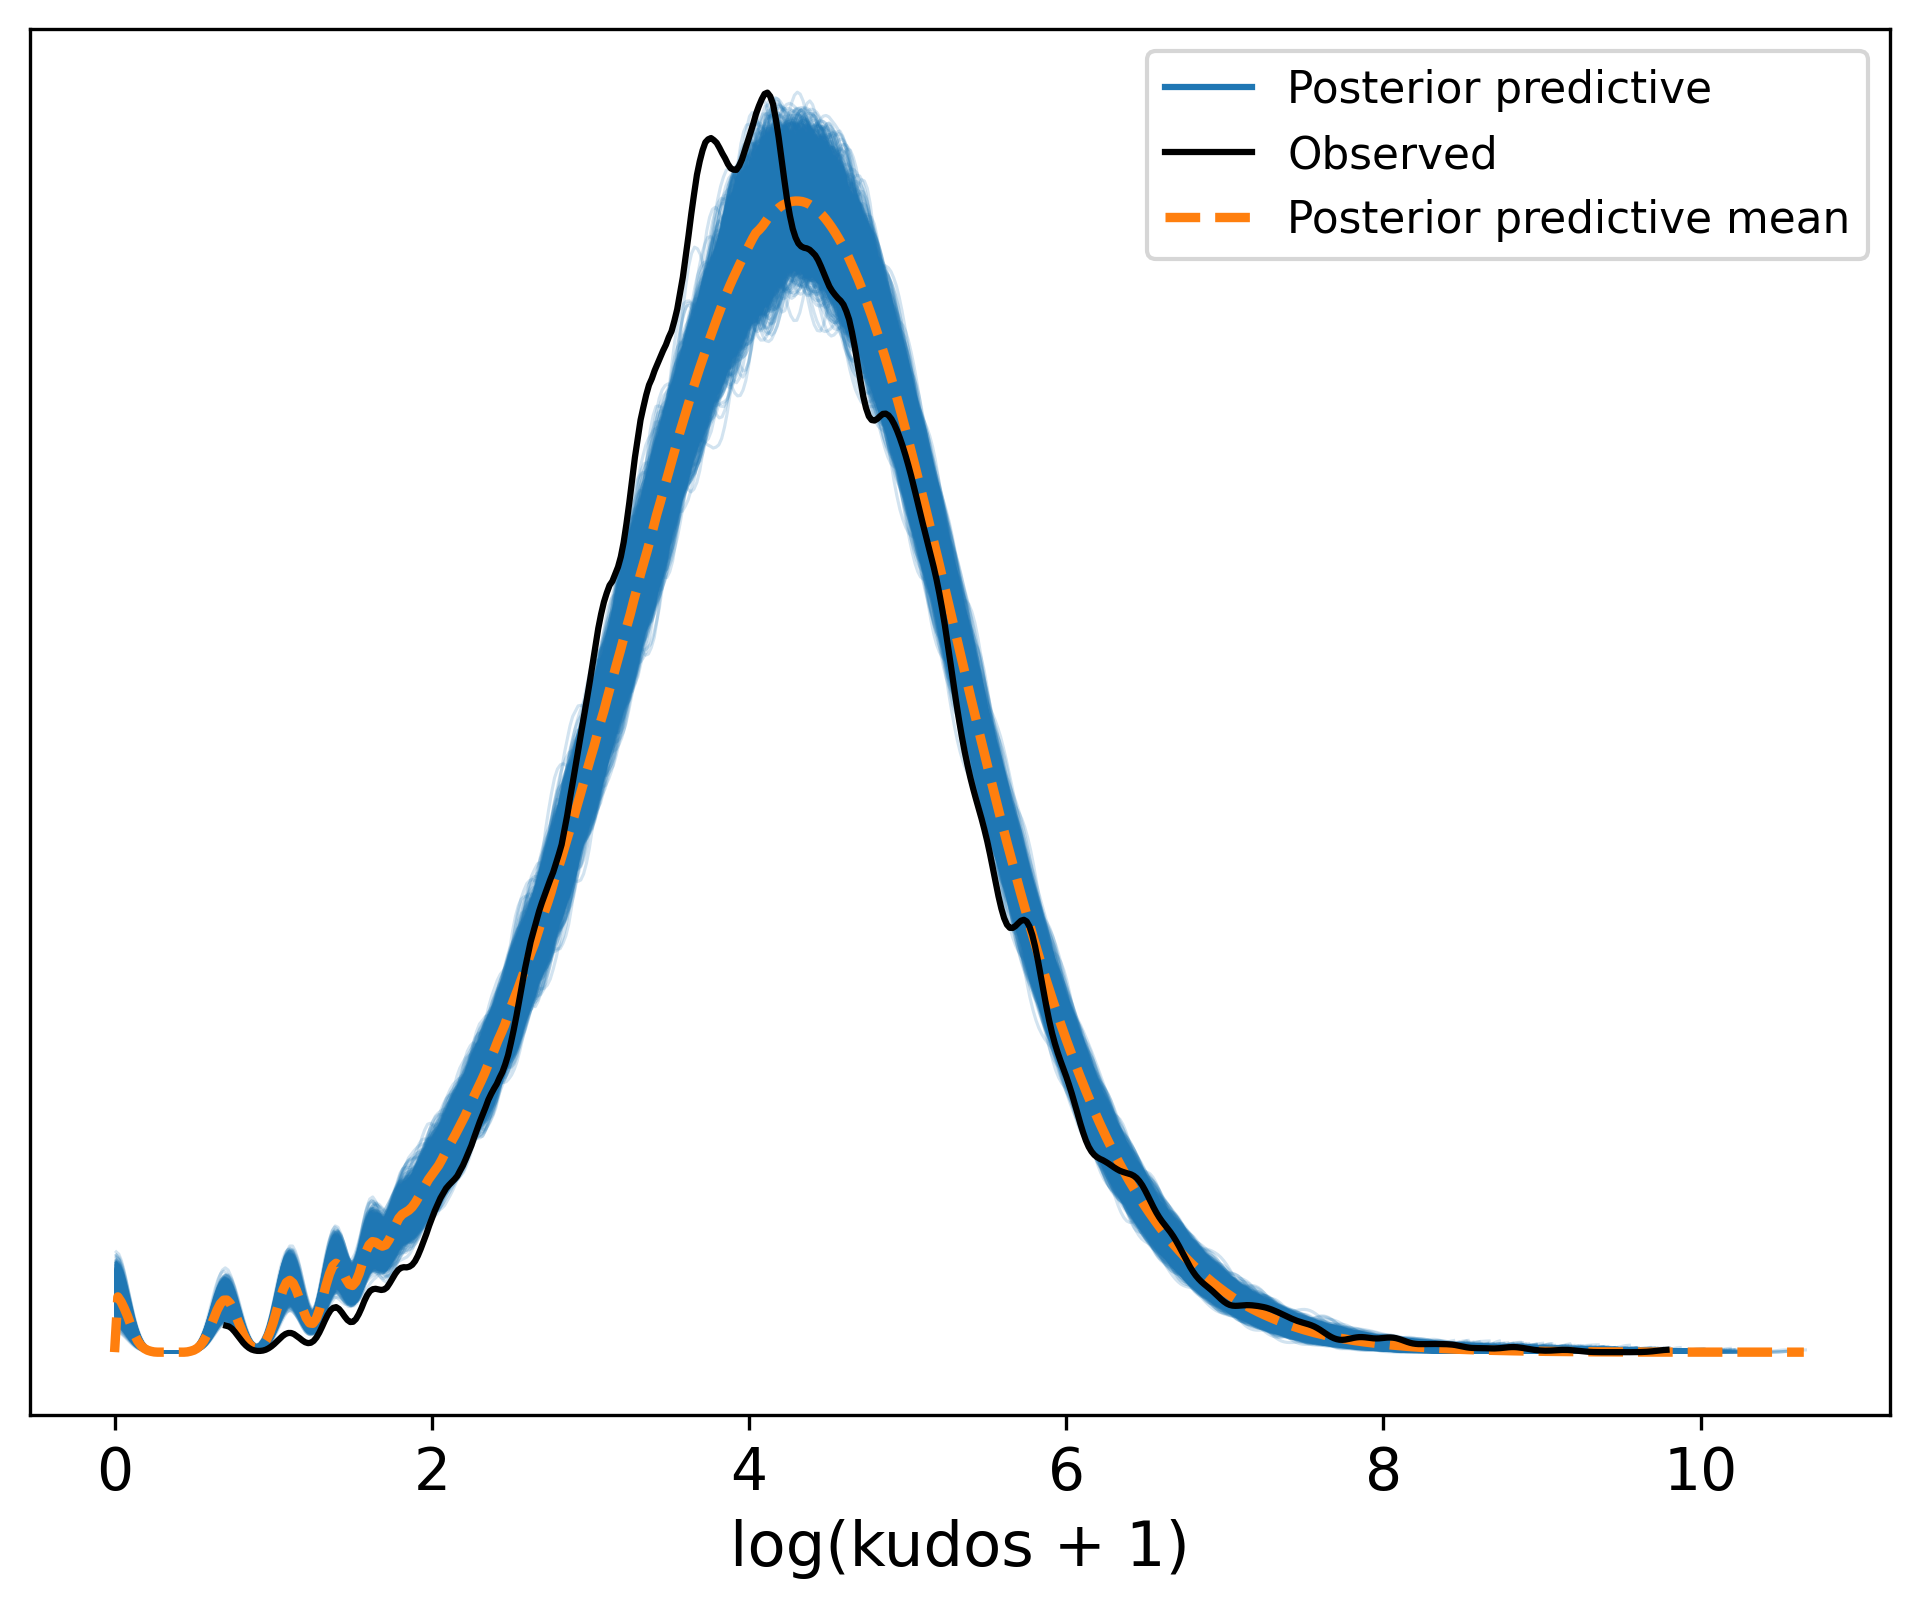

In [20]:
plot_ppc_log(
    m4,
    idata4,
    "kudos",
)

> ANSWER
>
> It looks like the author has more effect on the kudos, because when we stratify by author the PPC fits the observations much better.
> The predicted kudos effect based on date has dramatically decreased. This is good! It is saying that a lot of the final kudos for the work comes from other factors, so we are more accurately modelling our hypothesised age effect.

## Model Comparison

Using the method `az.compare`, compare your four models. Which is the best?

> NOTE: you will see some warnings here. Just ignore them.

/Users/ben/conda/miniconda3/envs/bambi/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/ben/conda/miniconda3/envs/bambi/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/ben/conda/miniconda3/envs

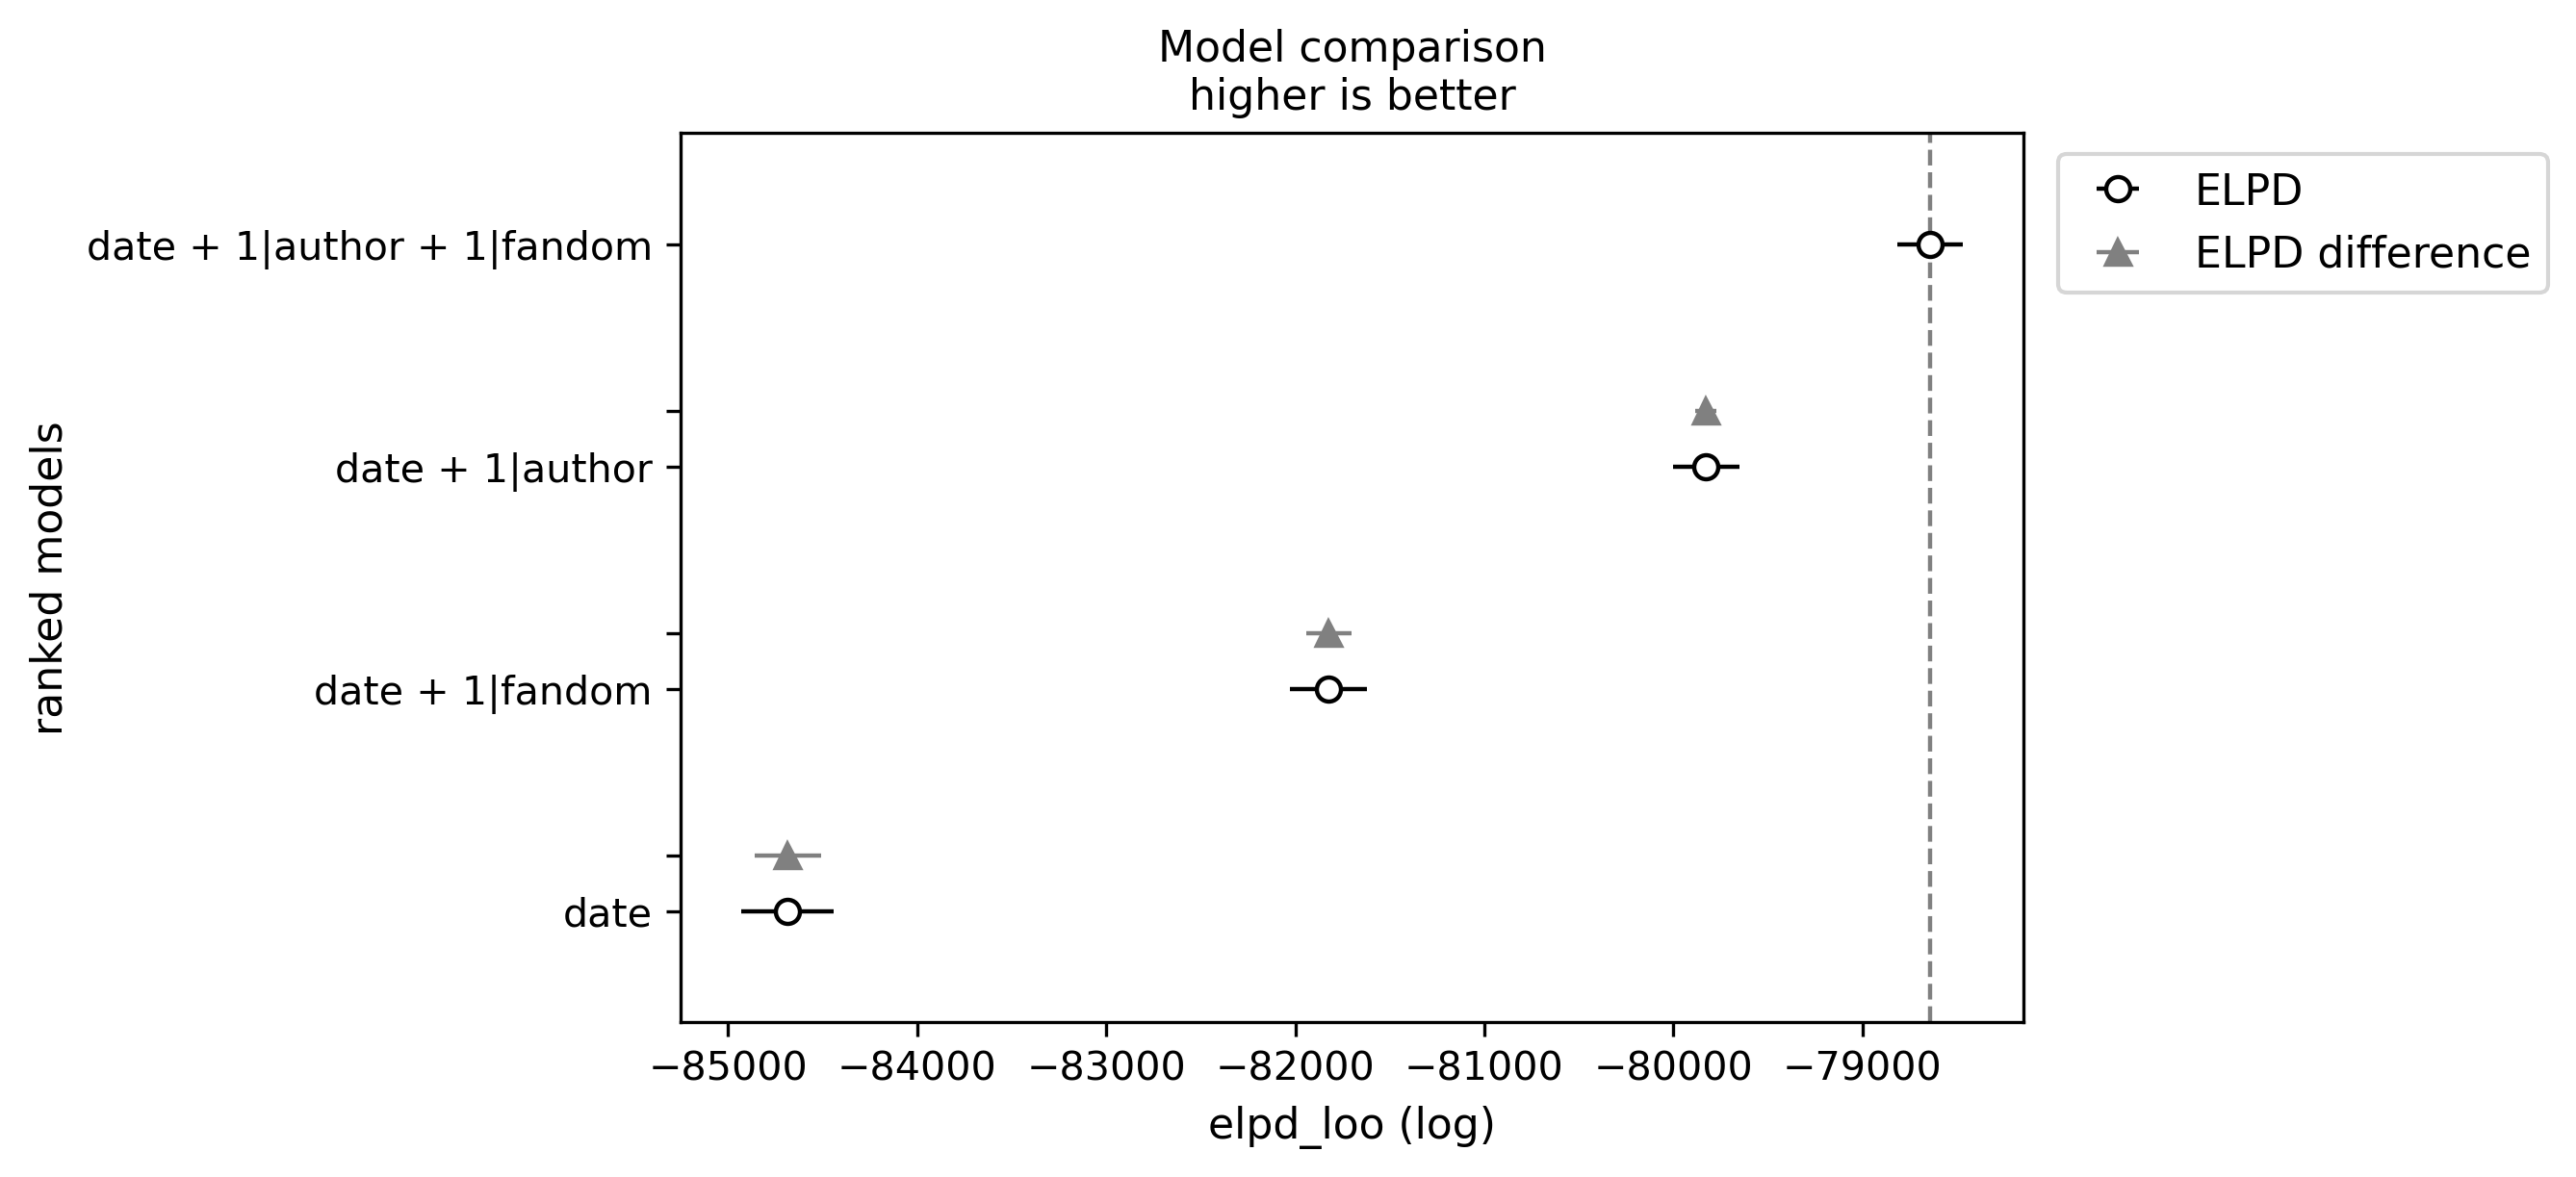

In [21]:
comp = az.compare(
    {
        "date": idata,
        "date + 1|author": idata2,
        "date + 1|fandom": idata3,
        "date + 1|author + 1|fandom": idata4,
    }
)
az.plot_compare(comp)
plt.show()

> ANSWER
>
> As can be seen by visually inspecting the curves, adding an author effect improved the model more than a fandom effect. So it seems that while these both contribute to the kudos, the popularity of the author is a bigger driver. Adding *both* effects also improved the predictive power of the model, so we should keep both of these effects.

## Mixed effects are meaningful!

If you take the summary output from `az.summary()` you get a pandas dataframe. Sort the values by the mean effect, and find the author with the most positive mean effect. Think about what this means. Now go back to the original dataframe, and find the authors there with the highest median `kudos`. Compare.

(This is a good chance to use `group_by` and `agg` from our very first pandas session)

In [22]:
summary4.sort_values(by="mean")

mean     sd  hdi_3%  \
1|fandom[Dark City (1998)]                         -1.760  0.234  -2.186   
1|author[zephyrprince]                             -1.744  0.232  -2.211   
1|fandom[Twilight Series - Stephenie Meyer, Twi... -1.621  0.481  -2.479   
1|author[zsomeone]                                 -1.558  0.464  -2.419   
1|author[Zexra]                                    -1.541  0.467  -2.421   
...                                                   ...    ...     ...   
1|author[zroe]                                      2.717  0.294   2.181   
1|fandom[Marvel]                                    2.729  0.336   2.067   
1|author[zeitgeistic (faire_weather)]               2.796  0.176   2.466   
1|author[zosofi]                                    3.156  0.207   2.783   
Intercept                                           4.122  0.025   4.079   

                                                    hdi_97%  mcse_mean  \
1|fandom[Dark City (1998)]                           -1.308      0.003   
1|author[zephyrprince]                               -1.339      0.004   
1|fandom[Twilight Series - Stephenie Meyer, Twi...   -0.679      0.006   
1|author[zsomeone]                                   -0.708      0.007   
1|author[Zexra]                                      -0.701      0.005   
...                                                     ...        ...   
1|author[zroe]                                        3.266      0.004   
1|fandom[Marvel]                                      3.348      0.005   
1|author[zeitgeistic (faire_weather)]                 3.131      0.002   
1|author[zosofi]                                      3.547      0.003   
Intercept                                             4.173      0.001   

                                                    mcse_sd  ess_bulk  \
1|fandom[Dark City (1998)]                            0.002    5537.0   
1|author[zephyrprince]                                0.003    4125.0   
1|fandom[Twilight Series - Stephenie Meyer, Twi...    0.005    5915.0   
1|author[zsomeone]                                    0.005    3914.0   
1|author[Zexra]                                       0.004    7718.0   
...                                                     ...       ...   
1|author[zroe]                                        0.003    5062.0   
1|fandom[Marvel]                                      0.004    4309.0   
1|author[zeitgeistic (faire_weather)]                 0.002    5573.0   
1|author[zosofi]                                      0.002    5322.0   
Intercept                                             0.000    1419.0   

                                                    ess_tail  r_hat  
1|fandom[Dark City (1998)]                            3214.0    1.0  
1|author[zephyrprince]                                2860.0    1.0  
1|fandom[Twilight Series - Stephenie Meyer, Twi...    2942.0    1.0  
1|author[zsomeone]                                    2817.0    1.0  
1|author[Zexra]                                       2828.0    1.0  
...                                                      ...    ...  
1|author[zroe]                                        2911.0    1.0  
1|fandom[Marvel]                                      3007.0    1.0  
1|author[zeitgeistic (faire_weather)]                 2962.0    1.0  
1|author[zosofi]                                      2805.0    1.0  
Intercept                                             1948.0    1.0  

[5491 rows x 9 columns]

In [23]:
df.groupby("author")["kudos"].agg("median").sort_values().tail(10)

author
zeitgeistic (faire_weather)    1127.0
zamwessell                     1334.0
Zirakinbar                     1448.0
Carver Edlund (goshcas)        1492.0
Reyairia                       1624.0
zeprithy                       1799.0
ZoeReed                        2041.0
ZainClaw                       2243.0
zroe                           2537.0
zosofi                         3454.0
Name: kudos, dtype: float64

> ANSWER
>
> The most popular author by median kudos, zosofi, also has the highest modelled effect. Because it is positive, this means that zosofi's works will attract more kudos on average. However the sumary stats and the modelled effects don't match exactly. In our model, the second highest author effect is 10th in the median list. Without more investigation it's hard to say why. The number of works might be relevant, or there might be an effect from when the authors were writing.

## One Last Thing...

Finally, fan-fiction can be pretty racy stuff, with content from General Audiences stories about Pokémon up to and including (a lot of) outright pornography. Most works on AO3 have a *rating* as well as more specific content advisory keywords (which we have not included in this notebook!).

Your last task is to add the `rating` as a categorical predictor (no interactions). Compare that model with the previous ones using `az.compare()` to see if it improves predictions.


In [24]:
m5 = bmb.Model(
    "kudos ~ rating + scale(date) + (1|fandom) + (1|author)",
    df,
    family="negativebinomial",
)
idata5 = m5.fit(
    random_seed=rng,
    idata_kwargs={"log_likelihood": True},
    progressbar=True,
)
summary5 = az.summary(idata5)
summary5

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, Intercept, rating, scale(date), 1|fandom_sigma, 1|fandom_offset, 1|author_sigma, 1|author_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha                      2.105  0.028   2.056    2.161      0.001    0.000   
Intercept                  4.447  0.029   4.394    4.503      0.001    0.001   
rating[General Audiences] -0.533  0.024  -0.581   -0.489      0.000    0.000   
rating[Mature]            -0.233  0.024  -0.278   -0.188      0.000    0.000   
rating[Not Rated]         -0.498  0.034  -0.563   -0.437      0.001    0.000   
...                          ...    ...     ...      ...        ...      ...   
1|author[zzzsleeptalker]   0.083  0.485  -0.794    1.037      0.006    0.009   
1|author[zzzubat]          0.588  0.424  -0.227    1.358      0.007    0.005   
1|author[zzzz18]          -0.244  0.408  -1.021    0.505      0.006    0.005   
1|author[zzzzzz]          -0.092  0.495  -1.021    0.817      0.007    0.007   
1|author[zzzzzzzo]         0.138  0.206  -0.258    0.519      0.003    0.003   

                           ess_bulk  ess_tail  r_hat  
alpha                        2985.0    3106.0    1.0  
Intercept                    1516.0    2091.0    1.0  
rating[General Audiences]    2973.0    2920.0    1.0  
rating[Mature]               3256.0    2943.0    1.0  
rating[Not Rated]            3306.0    3095.0    1.0  
...                             ...       ...    ...  
1|author[zzzsleeptalker]     7655.0    2743.0    1.0  
1|author[zzzubat]            4046.0    2665.0    1.0  
1|author[zzzz18]             5237.0    3086.0    1.0  
1|author[zzzzzz]             4743.0    3249.0    1.0  
1|author[zzzzzzzo]           4220.0    2691.0    1.0  

[5495 rows x 9 columns]

<Axes: xlabel='log(kudos + 1)'>

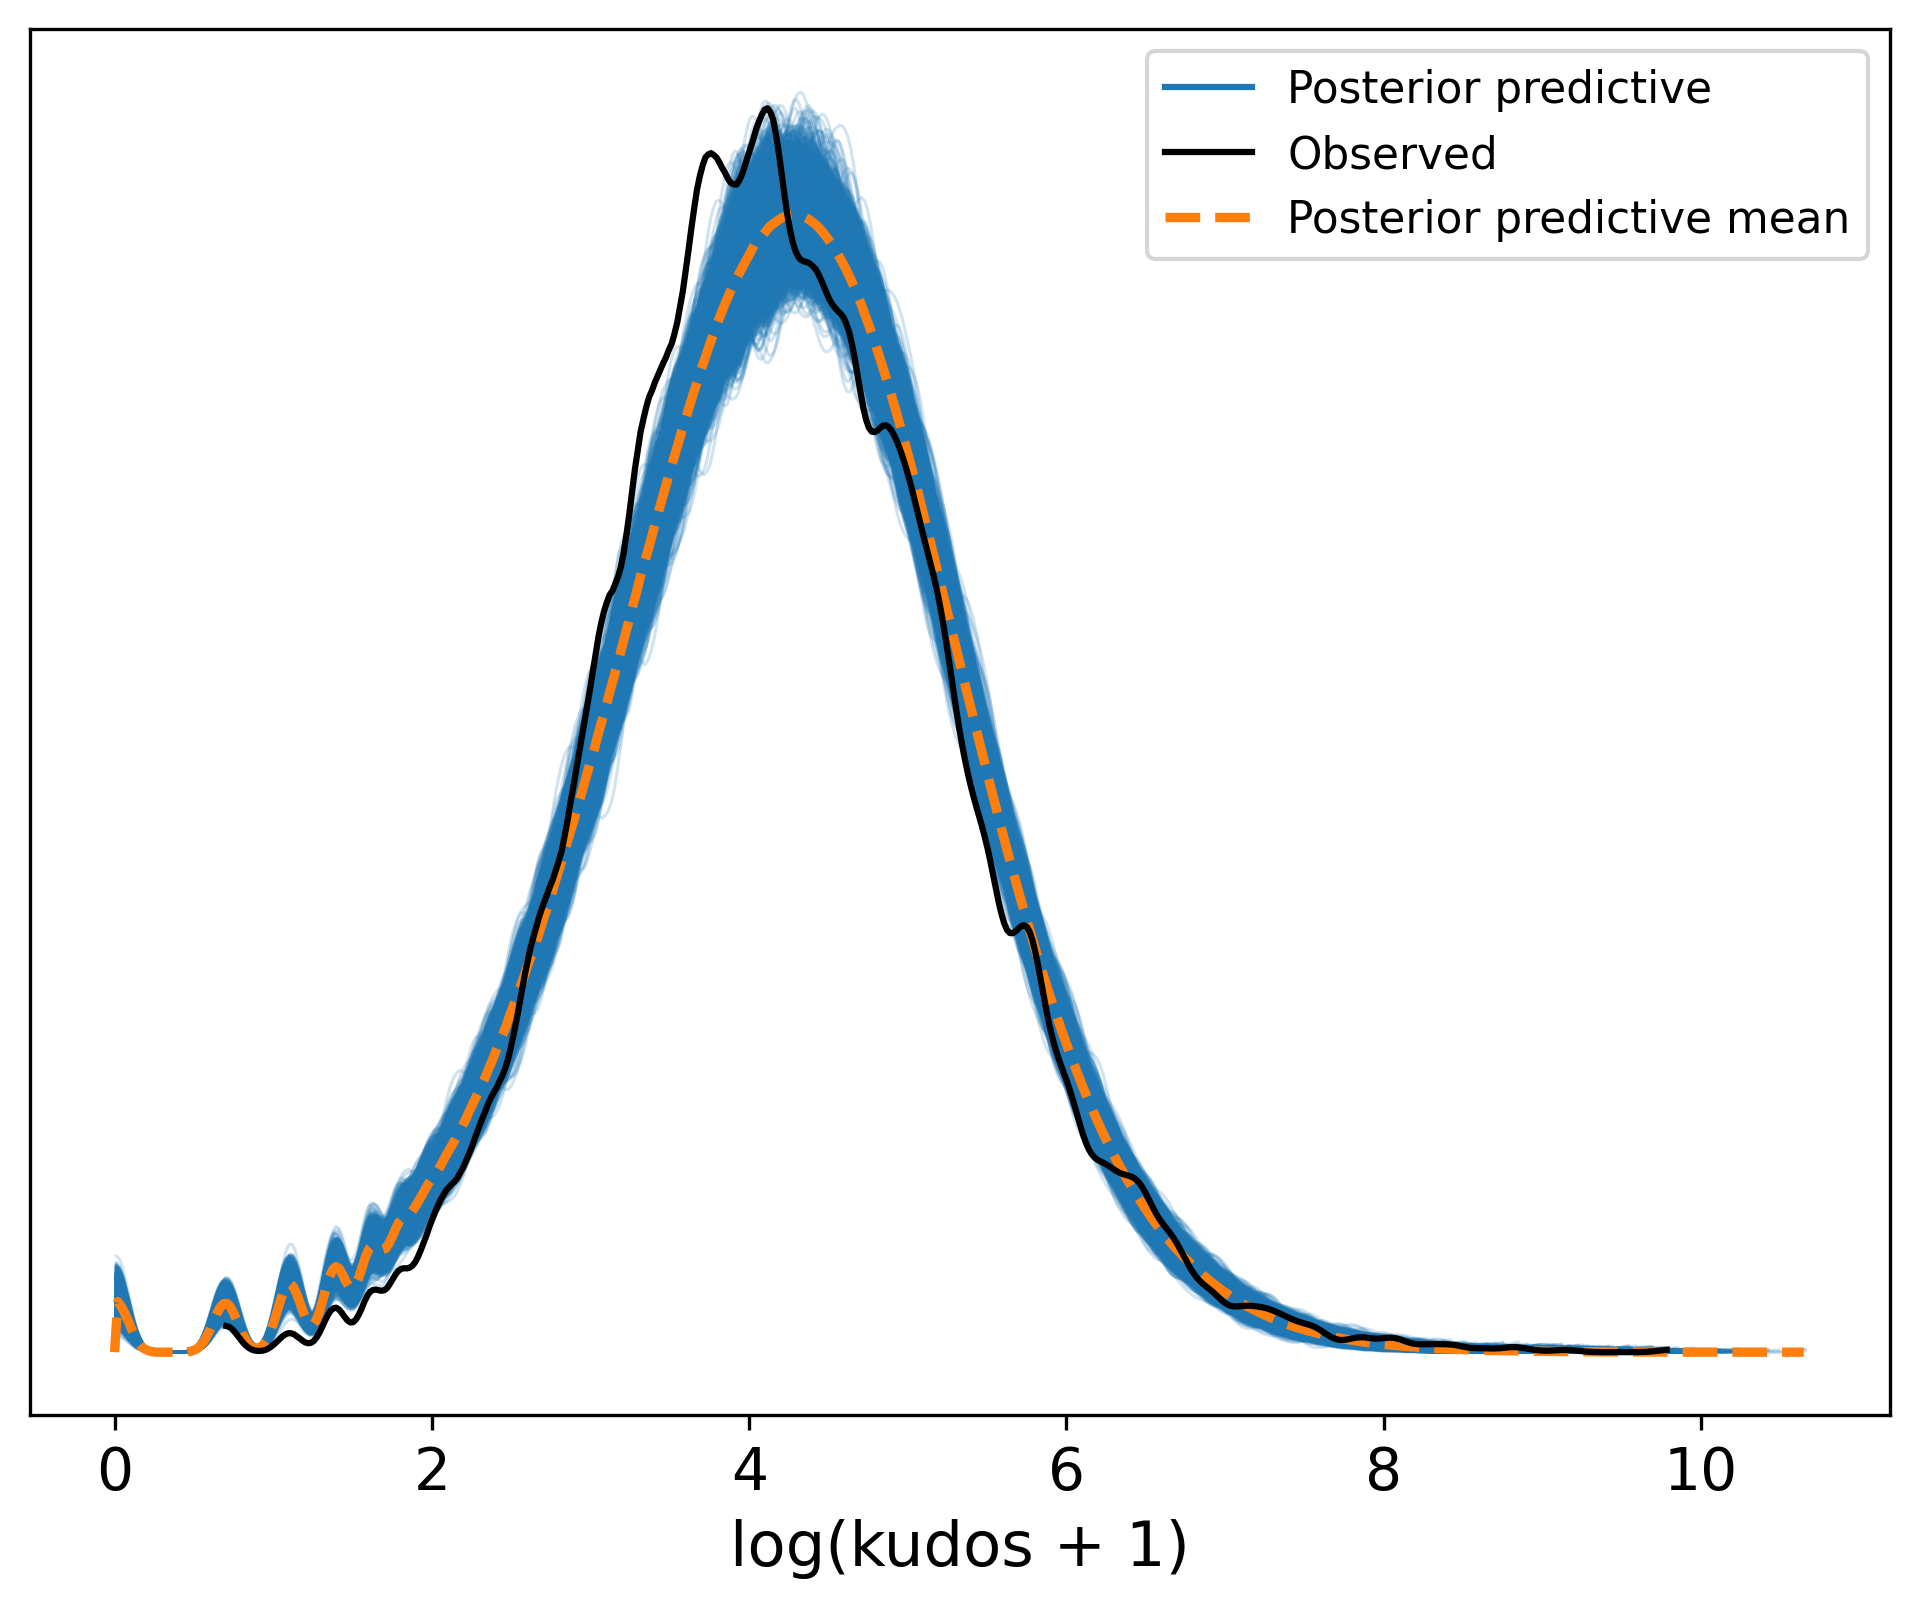

In [25]:
plot_ppc_log(
    m5,
    idata5,
    "kudos",
)

/Users/ben/conda/miniconda3/envs/bambi/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/ben/conda/miniconda3/envs/bambi/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/ben/conda/miniconda3/envs

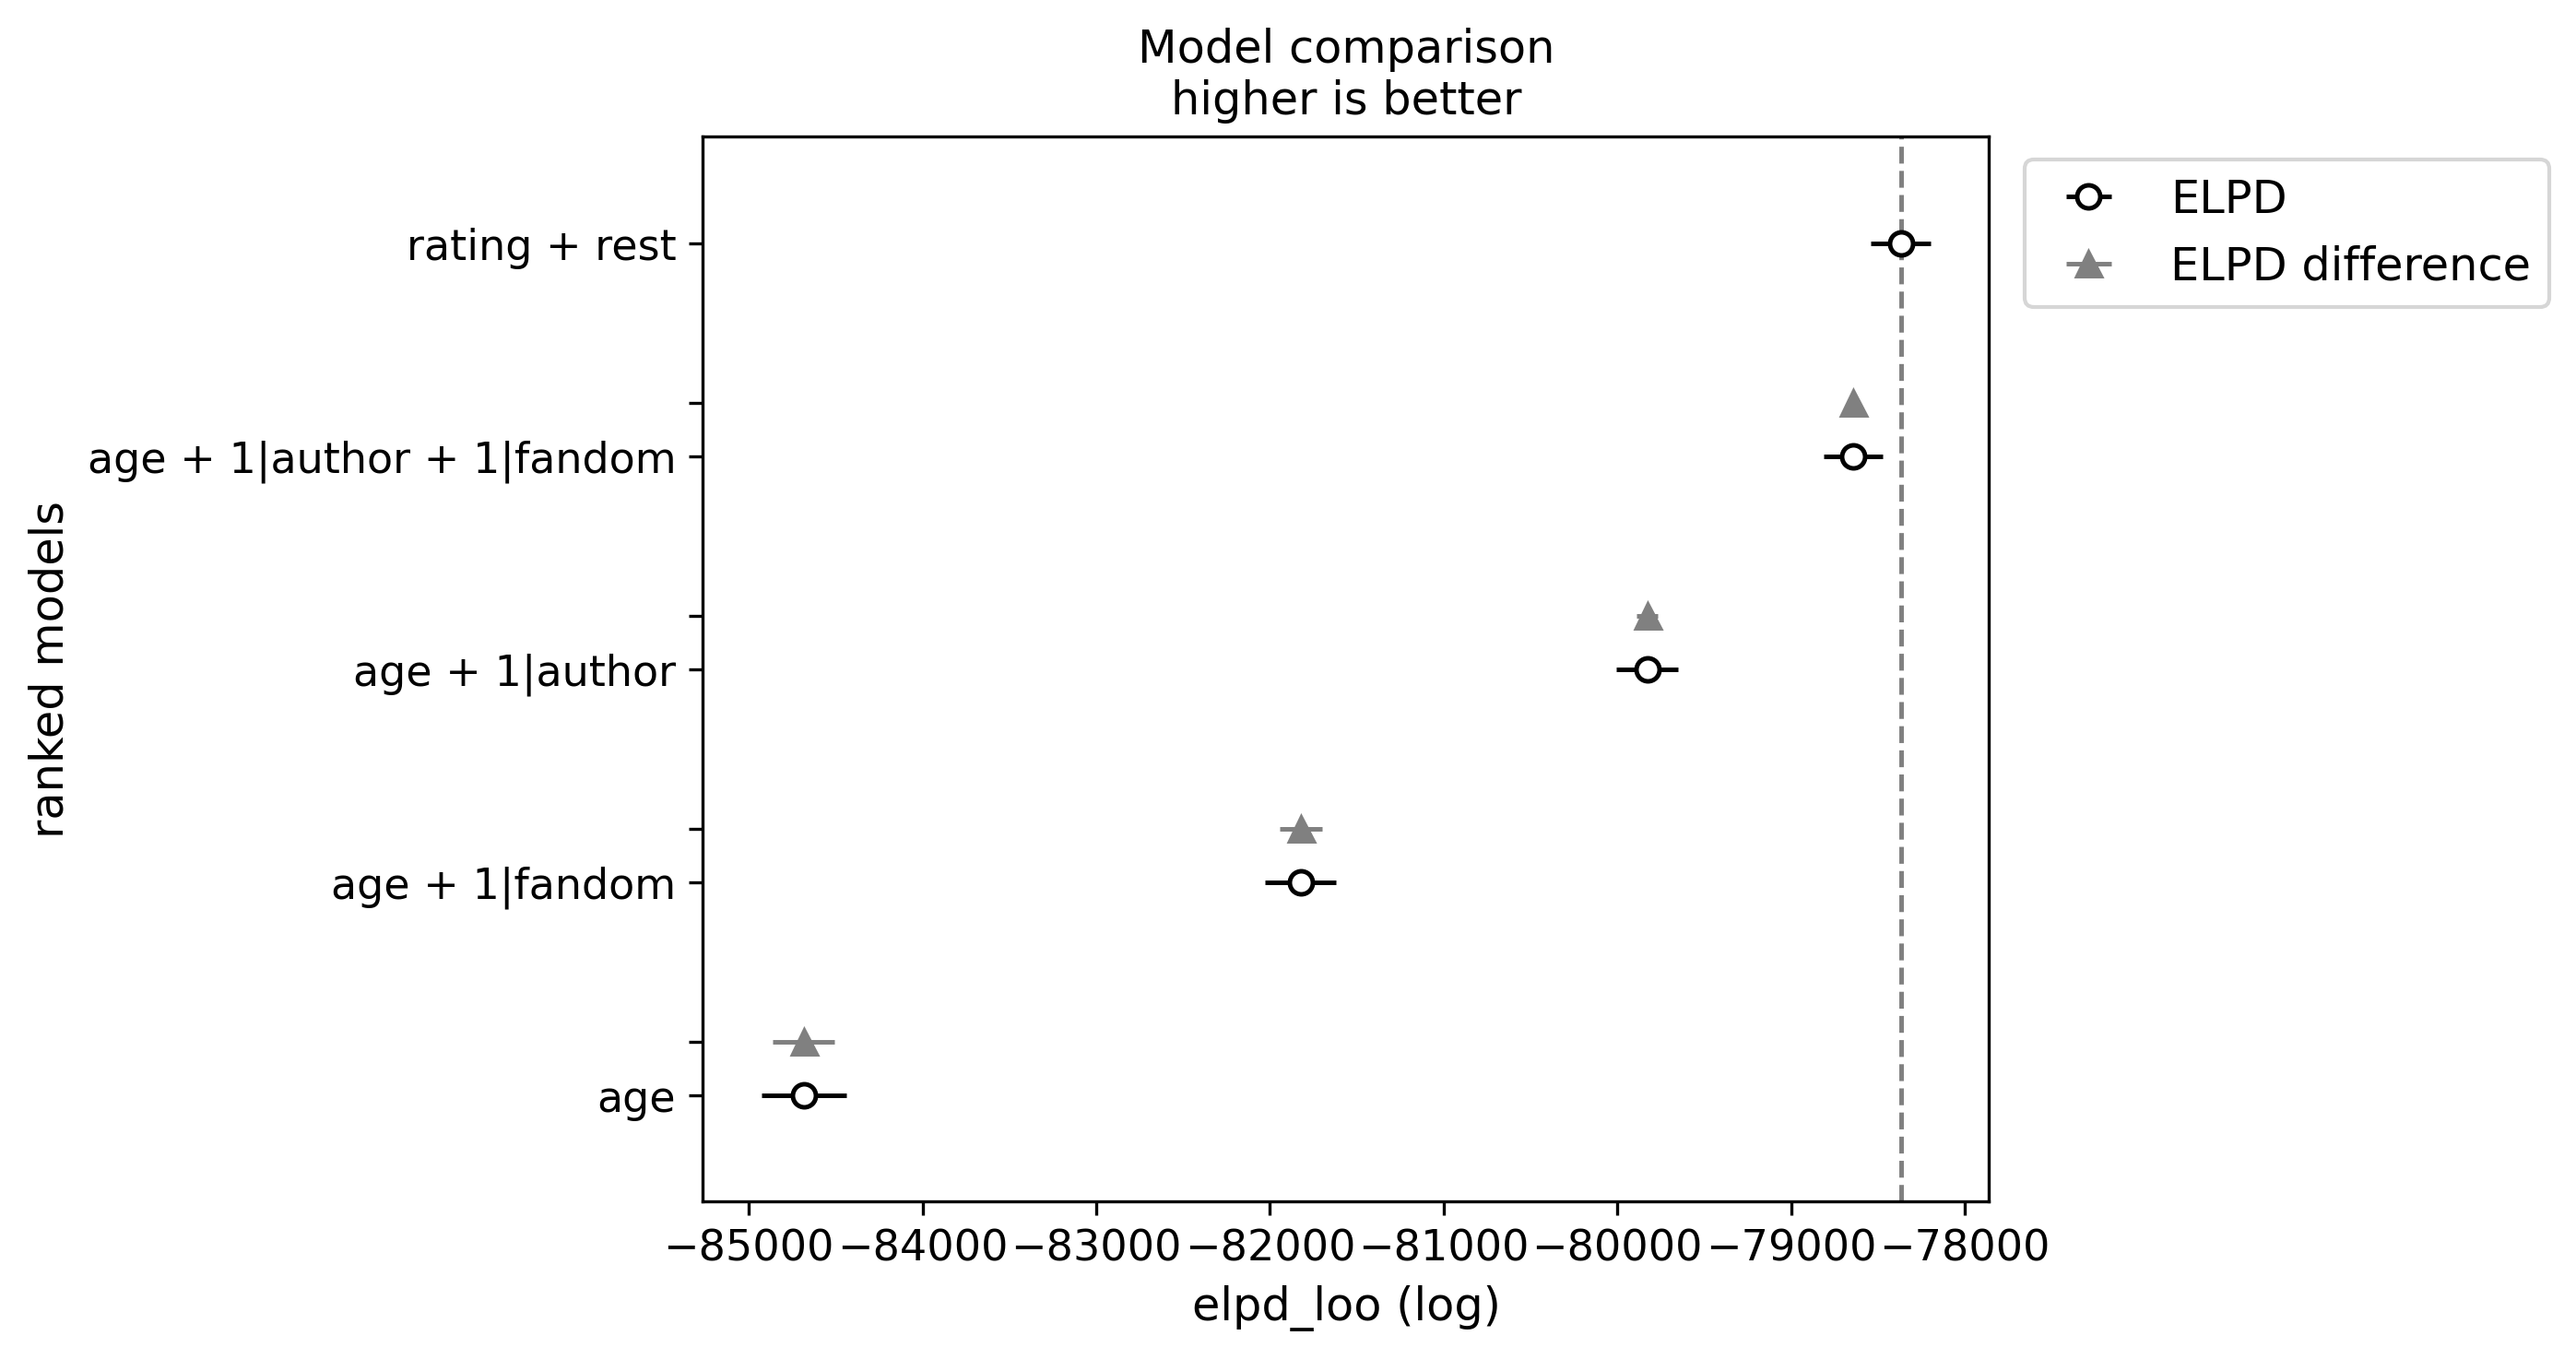

In [26]:
comp = az.compare(
    {
        "age": idata,
        "age + 1|author": idata2,
        "age + 1|fandom": idata3,
        "age + 1|author + 1|fandom": idata4,
        "rating + rest": idata5,
    }
)
az.plot_compare(comp)
plt.show()

> ANSWER
>
> The improvement is not huge, but it seems definitely real. Some ratings are inherently more popular than others!

## Plot the predictions per rating

Now plot the predictions, conditional on both `date` and `rating`. To make the layout better, add the following arguments to your `plot_predictions`:
```python
    fig_kwargs={"figsize": (20, 8), "sharey": True},
    subplot_kwargs={
        "main": "date",
        "group": "rating",
        "panel": "rating",
    },
    legend=False
```
This will break the different ratings into subplots. Interpret.

Default computed for conditional variable: date, rating
Default computed for unspecified variable: author, fandom


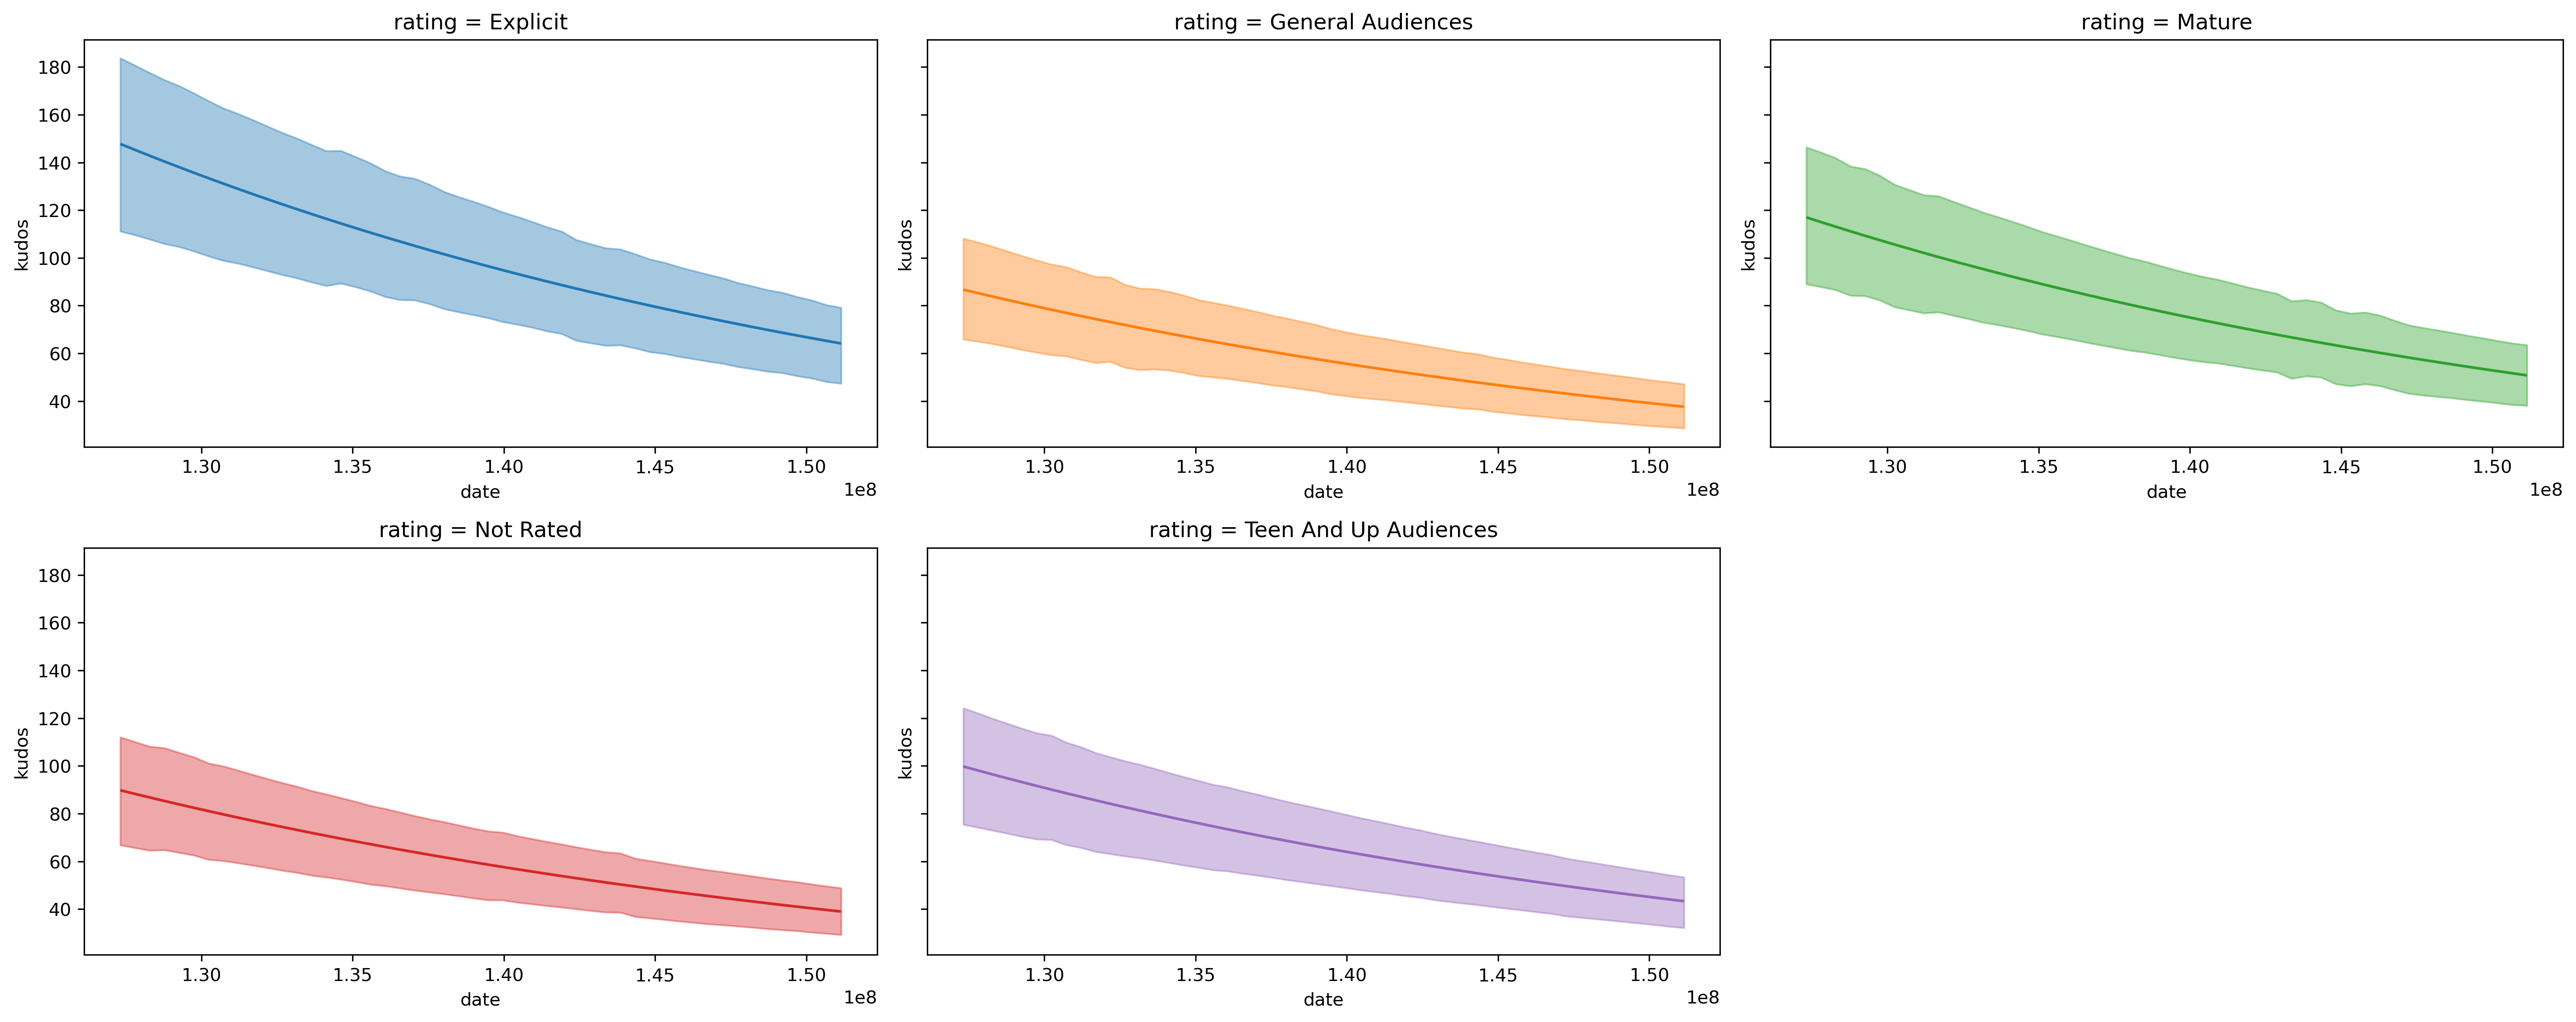

In [30]:
bmb.interpret.plot_predictions(
    m5,
    idata5,
    conditional=["date", "rating"],
    fig_kwargs={"figsize": (20, 8), "sharey": True},
    subplot_kwargs={
        "main": "date",
        "group": "rating",
        "panel": "rating",
    },
    legend=False,
)
plt.tight_layout()
plt.show()

> ANSWER
>
> In a completely unsurprising turn of events, the most popular ratings are "Explicit" and "Mature".

# CONGRATULATIONS!

In this course you have progressed from simple descriptive statistics and basic uni- and bi-variate tests, to fully developed methods of Bayesian inference that are suitable for cutting-edge analysis on real problems in many fields.

Please, though, remember:
1. Statistics have no inherent value in the absence of *your* expertise and ideas
2. Always be honest! Sometimes the answers aren't in the data (there's too much uncertainty), and sometimes the answers aren't the ones we hoped for, and *that's OK*. Always do the best job you can, and describe your results (and problems) honestly and completely. 

Now go forth, and research!


```
Version History

Current: v1.0.0

20/11/24: 1.0.0: first draft, BN
```